In [1]:
import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
# set working directory 
import os
os.chdir("/hpc/group/goldsteinlab/vmd13/Python/250131_TCR_data")

In [3]:
mdata = mu.read_h5mu("/hpc/group/goldsteinlab/sk733/adata_gex_tcr_onlytcrsequenced_scVI.h5mu")

/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/anndata/utils.py:349: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)
/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) t

In [ ]:
import scirpy as ir

ir.pl.vdj_usage(
    mdata,
    vdj_cols=[
        'VJ_1_v_call',
        'VJ_1_j_call',
        'VDJ_1_v_call',
        'VDJ_1_d_call',
        'VDJ_1_j_call'
    ],
    normalize_to="airr:orig_patients",  # or just "orig_patients" if that's the column name in mdata["airr"].obs
    airr_mod="airr",           # Only needed if your AIRR data are in a modality named other than "airr"
    chain_idx_key="chain_indices"
)


In [4]:
import pandas as pd

# 1) Define your renaming dictionaries for "cond":
rename_cond_dict = {
    "normosmic": "Normosmic",
    "hyposmic":  "Hyposmic",
    # Adjust keys if your data has different spelling/case
}

# 2) Define the order you want for "cond":
cond_order = ["Normosmic", "Hyposmic"]

# 3) Define your renaming dictionary for patients:
rename_patients_dict = {
    "H2024_7":  "Normosmic 1",
    "H2024_14": "Normosmic 2",
    "H2024_28": "Normosmic 3",
    "H2024_2":  "Hyposmic 1",
    "H2024_5":  "Hyposmic 2",
    "H2024_29": "Hyposmic 3",
    # Add or adjust entries to match your dataset
}

# 4) Define the order you want for patients:
desired_patients_order = [
    "Normosmic 1", "Normosmic 2", "Normosmic 3",
    "Hyposmic 1", "Hyposmic 2", "Hyposmic 3"
]

# 5) Loop over both "airr" and "gex" layers, applying the same logic:
for prefix in ["airr", "gex"]:
    # A) Rename conditions
    mdata.obs[f"{prefix}:cond"] = mdata.obs[f"{prefix}:cond"].replace(rename_cond_dict)
    
    # B) Convert to ordered categorical
    mdata.obs[f"{prefix}:cond"] = pd.Categorical(
        mdata.obs[f"{prefix}:cond"],
        categories=cond_order,
        ordered=True
    )
    
    # C) Rename patients
    mdata.obs[f"{prefix}:orig_patients"] = (
        mdata.obs[f"{prefix}:orig_patients"].replace(rename_patients_dict)
    )
    
    # D) Convert patients to ordered categorical
    mdata.obs[f"{prefix}:orig_patients"] = pd.Categorical(
        mdata.obs[f"{prefix}:orig_patients"],
        categories=desired_patients_order,
        ordered=True
    )


/tmp/ipykernel_1093520/2630540266.py:33: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mdata.obs[f"{prefix}:cond"] = mdata.obs[f"{prefix}:cond"].replace(rename_cond_dict)
/tmp/ipykernel_1093520/2630540266.py:44: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  mdata.obs[f"{prefix}:orig_patients"].replace(rename_patients_dict)


In [ ]:
#adata.write("adata_gex_only_from_onlytcrsequenced_scVI.h5ad")

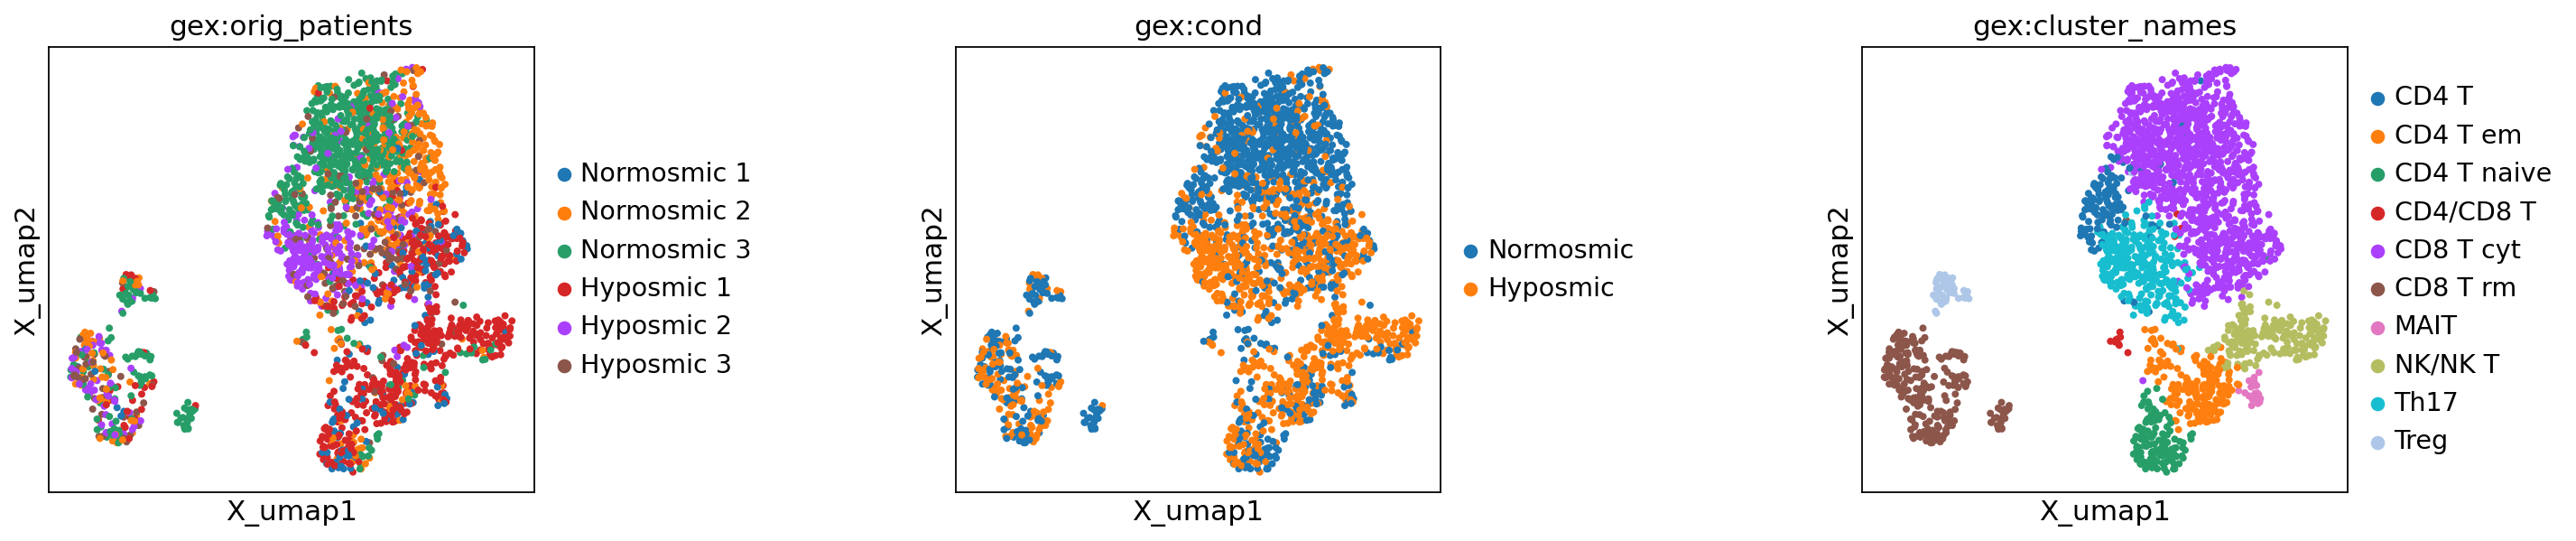

In [5]:
mu.pl.embedding(
    mdata,
    basis="gex:X_umap",
    color=["gex:orig_patients", "gex:cond", "gex:cluster_names"],
    ncols=3,
    wspace=0.7,
)


In [6]:
ir.pp.index_chains(mdata)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


In [7]:
ir.tl.chain_qc(mdata)

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


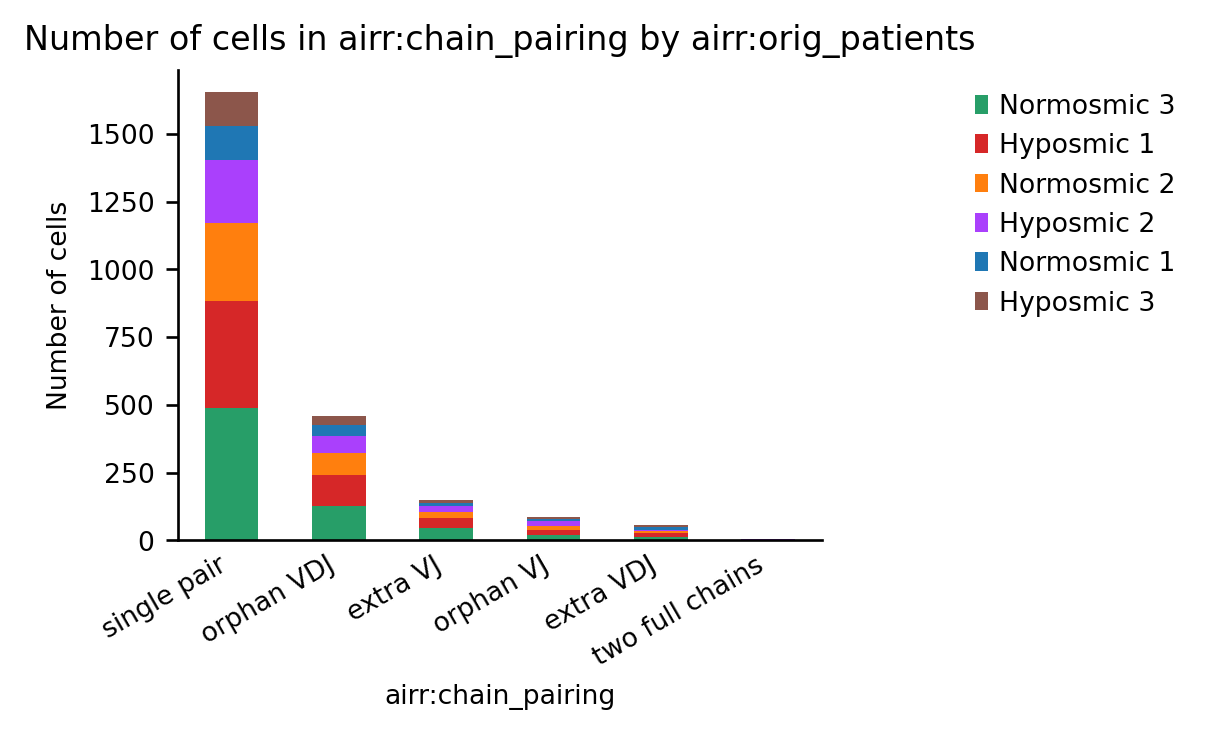

In [8]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="airr:chain_pairing",
    target_col="airr:orig_patients",
)

# Grab the figure from the axes
fig = ax.figure

# Save the figure as an SVG
fig.savefig("sup_chainpairing_by_orig_patients.svg", bbox_inches="tight")


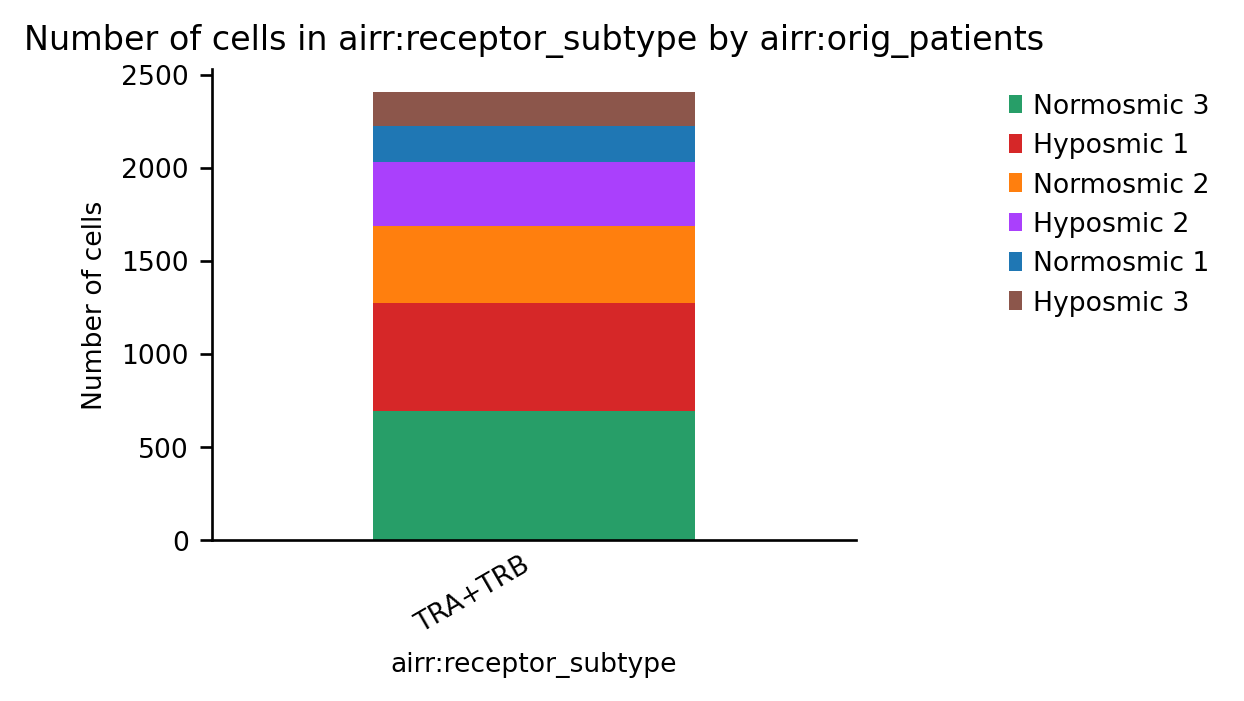

In [9]:
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="airr:orig_patients")

In [10]:
import numpy as np
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.09


In [11]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x != "multichain")

In [12]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))

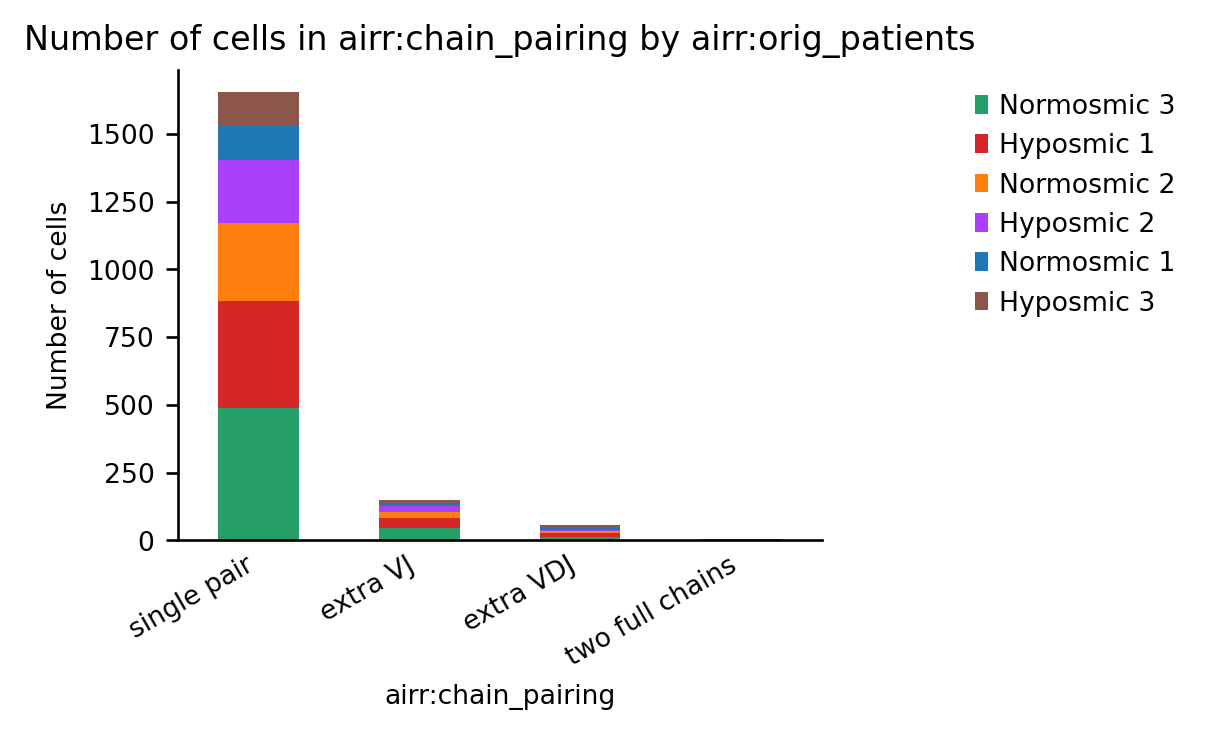

In [13]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="airr:orig_patients")

# Grab the figure from the axes
fig = ax.figure

# Save the figure as an SVG
#fig.savefig("sup_chainpairing_by_orig_patients_after_qc.svg", bbox_inches="tight")


In [14]:
vdjdb = ir.datasets.vdjdb()

In [15]:
ir.pp.ir_dist(mdata, vdjdb, metric="identity", sequence="aa")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [16]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="all",
    dual_ir="any",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored IR distance matrix in `adata.uns["ir_query_VDJDB_aa_identity"]`.


In [17]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
    strategy="most-frequent",
)

  0%|          | 0/24 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:antigen.species"]`.
Stored result in `mdata.obs["airr:antigen.gene"]`.


/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]
/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]


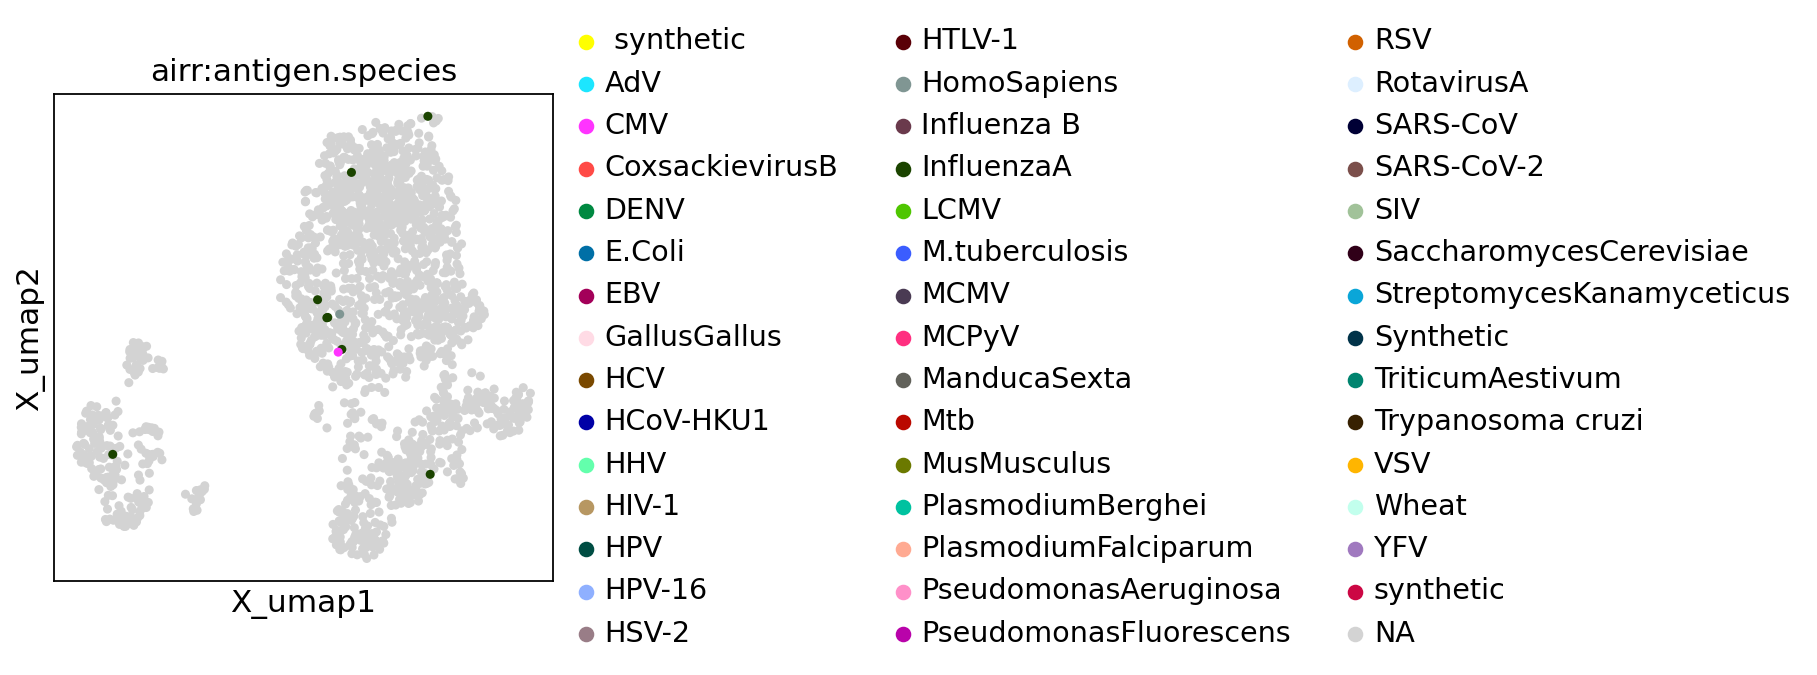

In [29]:
mu.pl.embedding(mdata, "gex:umap", color="airr:antigen.species")

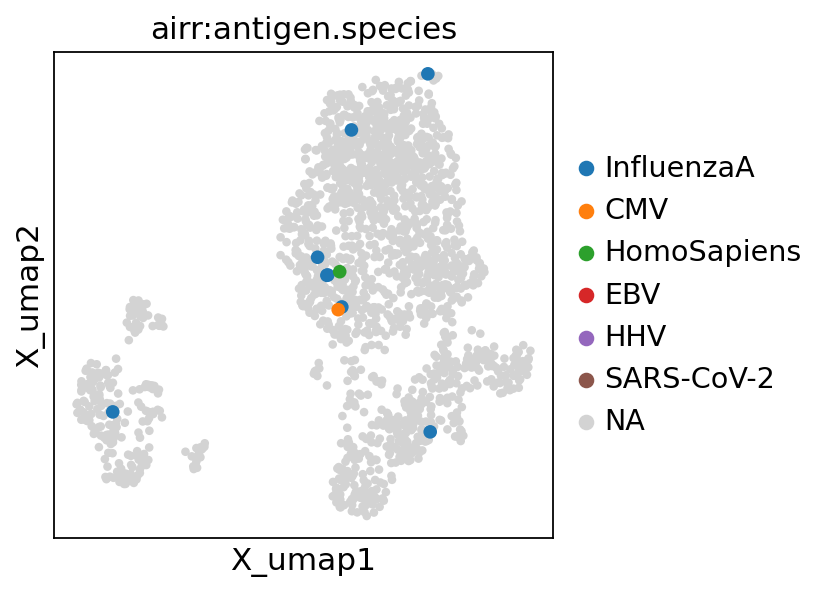

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Define the categories for airr:antigen.species
all_species = ["InfluenzaA", "CMV", "HomoSapiens", "EBV", "HHV", "SARS-CoV-2"]
mdata.obs["airr:antigen.species"] = pd.Categorical(
    mdata.obs["airr:antigen.species"],
    categories=all_species
)

# 2) Define a custom color palette matching the order of `all_species`
custom_colors = [
    "#1f77b4",  # color for InfluenzaA
    "#ff7f0e",  # color for CMV
    "#2ca02c",  # color for HomoSapiens
    "#d62728",  # color for EBV
    "#9467bd",  # color for HHV
    "#8c564b",  # color for SARS-CoV-2
]

# 3) Create a size array to make not-NA cells larger
notna_mask = mdata.obs["airr:antigen.species"].notna()
sizes = np.where(notna_mask, 150, 60)

# 4) Plot the UMAP using mu.pl.embedding
fig, ax = plt.subplots()

mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:antigen.species",
    palette=custom_colors,  # use custom palette
    size=sizes,
    ax=ax,
    show=False  # Don't display immediately
)

# 5) Save as SVG
plt.savefig("250303_umap_ag_species.svg")

# 6) Optionally display
plt.show()


/hpc/group/goldsteinlab/envs/py3_11/lib/python3.11/site-packages/muon/_core/plot.py:263: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{key}_colors"] = ad.uns[f"{col}_colors"]


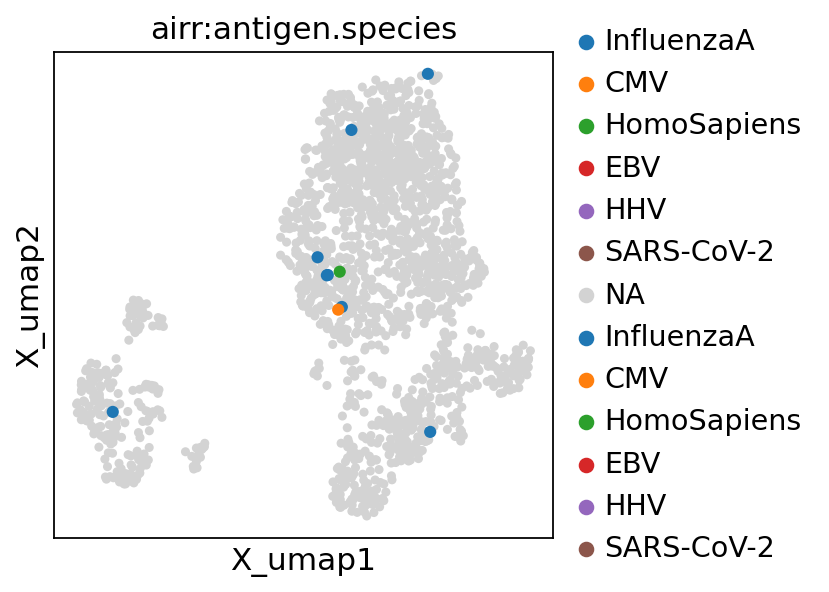

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# 1) Plot all cells (including NA) with default auto-sizing
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:antigen.species",
    size=None,  # Omit or use None for default
    ax=ax,
    show=False
)

# 2) Plot only non-NA cells (making them larger) over the same axes
not_na = mdata[mdata.obs["airr:antigen.species"].notna(), :]
mu.pl.embedding(
    not_na,
    basis="gex:umap",
    color="airr:antigen.species",
    size=120,   # A larger size for non-NA cells
    ax=ax,
    show=False
)

plt.show()


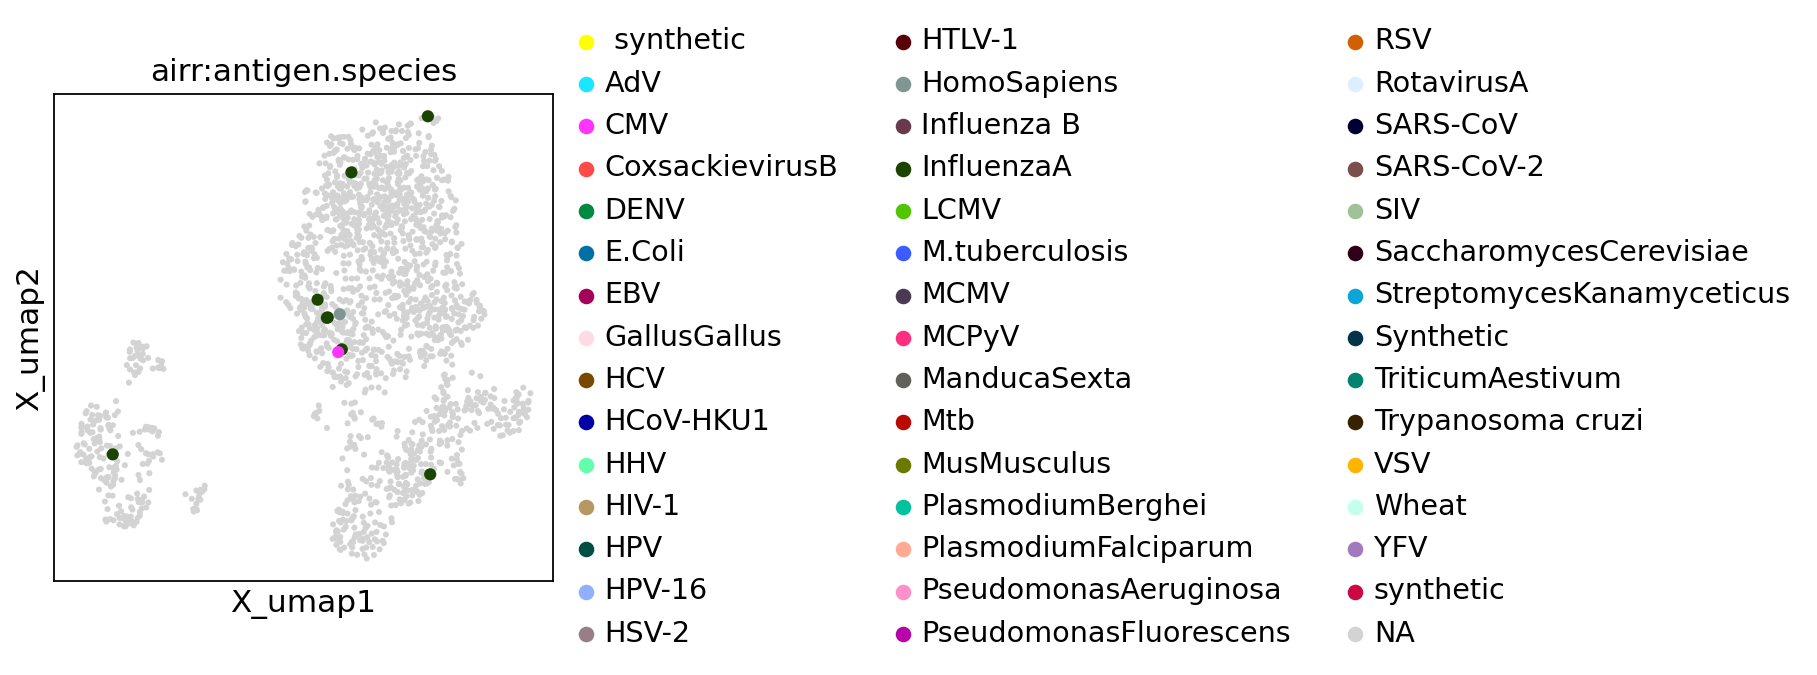

In [34]:
import numpy as np

# Create a numeric array that is larger for not-NA, smaller for NA
notna_mask = mdata.obs["airr:antigen.species"].notna()
sizes = np.where(notna_mask, 120, 30)  # pick any numbers you want

mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:antigen.species",
    size=sizes,
) 


In [31]:
# 1) Just show unique species (excluding NaNs)
species_list = mdata.obs["airr:antigen.species"].dropna().unique()
print("Unique airr:antigen.species hits:")
print(species_list)

# 2) Show how many cells each species corresponds to
species_counts = mdata.obs["airr:antigen.species"].value_counts(dropna=True)
print("\nCounts of each species:")
print(species_counts)

# 1) Just show unique species (excluding NaNs)
gene_list = mdata.obs["airr:antigen.gene"].dropna().unique()
print("Unique airr:antigen.gene hits:")
print(gene_list)

# 2) Show how many cells each species corresponds to
gene_counts = mdata.obs["airr:antigen.gene"].value_counts(dropna=True)
print("\nCounts of each species:")
print(gene_counts)





Unique airr:antigen.species hits:
['InfluenzaA', 'CMV', 'HomoSapiens']
Categories (44, object): [' synthetic', 'AdV', 'CMV', 'CoxsackievirusB', ..., 'VSV', 'Wheat', 'YFV', 'synthetic']

Counts of each species:
airr:antigen.species
InfluenzaA                   10
CMV                           1
HomoSapiens                   1
 synthetic                    0
DENV                          0
E.Coli                        0
EBV                           0
GallusGallus                  0
HCV                           0
HCoV-HKU1                     0
AdV                           0
CoxsackievirusB               0
HIV-1                         0
HHV                           0
HPV                           0
HPV-16                        0
HTLV-1                        0
HSV-2                         0
Influenza B                   0
LCMV                          0
M.tuberculosis                0
MCMV                          0
MCPyV                         0
ManducaSexta                  0
M

In [33]:
import pandas as pd

# Drop rows where airr:antigen.species is missing
df = mdata.obs.dropna(subset=["airr:antigen.species"])

# Group by patient and species, then count
grouped = (
    df.groupby(["airr:orig_patients", "airr:antigen.species"])
    .size()
    .reset_index(name="count")
)

grouped

grouped.to_csv("patient_species_counts.csv", index=False)



/tmp/ipykernel_1093520/1914572363.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["airr:orig_patients", "airr:antigen.species"])


In [ ]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

In [ ]:
ir.tl.clonal_expansion(mdata)

In [ ]:
mdata

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1) PREPARE YOUR DATA
# ------------------------------------------------------
df = mdata.obs.copy()

# Mark each cell/clone as "is_expanded" if airr:clonal_expansion == "> 2"
df["is_expanded"] = df["airr:clonal_expansion"].eq("> 2")

# ------------------------------------------------------
# 2) GROUP TO IDENTIFY UNIQUE CLONES & WHETHER THEY'RE EXPANDED
# ------------------------------------------------------
grouped = (
    df.groupby(["gex:cluster_names", "airr:orig_patients", "airr:cond", "airr:clone_id"], observed=True)
    .agg(
        is_expanded=("is_expanded", "any")  # True if ANY cell in that clone_id is expanded
    )
    .reset_index()
)

# ------------------------------------------------------
# 3) COUNT HOW MANY UNIQUE CLONES ARE EXPANDED PER (SUBSET, PATIENT, CONDITION)
# ------------------------------------------------------
clone_counts = (
    grouped.groupby(["gex:cluster_names", "airr:orig_patients", "airr:cond"], observed=True)["is_expanded"]
    .agg(
        expanded_clones="sum",  # number of distinct expanded clones
        total_clones="count"
    )
    .reset_index()
)

# (Optional) proportion of expanded clones
clone_counts["proportion_expanded_clones"] = clone_counts["expanded_clones"] / clone_counts["total_clones"]

# ------------------------------------------------------
# 4) ORDER SUBSETS BY THE MEAN # OF EXPANDED CLONES, DESCENDING
# ------------------------------------------------------
cluster_means = (
    clone_counts
    .groupby("gex:cluster_names")["expanded_clones"]
    .mean()
    .sort_values(ascending=False)
)
cluster_order = cluster_means.index.tolist()

# ------------------------------------------------------
# 5) CREATE THE HORIZONTAL BARPLOT + STRIPPLOT
# ------------------------------------------------------
sns.set_style("white")
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:cond",
    ci="sd",
    edgecolor="black",
    order=cluster_order,
    orient="h"
)

sns.stripplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:orig_patients",
    order=cluster_order,
    orient="h",
    dodge=True,
    alpha=0.7,
    size=5,
    ax=ax
)

plt.title("Number of Expanded Clones (Unique) by Condition (Horizontal)")
plt.xlabel("Expanded Clones")
plt.ylabel("T Cell Subset (Cluster)")

# Clip the x-axis at zero
plt.xlim(left=0)

# ------------------------------------------------------
# 6) MANAGE LEGENDS
# ------------------------------------------------------
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

n_cond = clone_counts["airr:cond"].nunique()

cond_handles = handles[:n_cond]
cond_labels  = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Legend for condition
l1 = plt.legend(
    cond_handles, cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
ax.add_artist(l1)

# Legend for patients
plt.legend(
    patient_handles, patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.7),
    loc="upper left"
)

plt.tight_layout()
plt.savefig("250228_expanded_clones_horizontal.svg", format="svg", bbox_inches="tight") #
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Count cells in each (cluster, condition)
counts = (
    mdata.obs
    .groupby(["gex:cluster_names", "gex:cond"], observed=True)
    .size()
    .reset_index(name="cell_count")
)

# 2) Convert to percentages within each cluster
counts["pct"] = (
    counts.groupby("gex:cluster_names")["cell_count"]
    .transform(lambda x: 100 * x / x.sum())
)

# 3) Pivot: rows = cluster, columns = condition, values = percentages
pivoted = counts.pivot(
    index="gex:cluster_names",
    columns="gex:cond",
    values="pct"
)

# 4) Sort by the fraction of (for example) "Hyposmic" in descending order
#    If your condition is named differently, substitute it here.
if "Normosmic" in pivoted.columns:
    pivoted = pivoted.loc[
        pivoted["Normosmic"].sort_values(ascending=False).index
    ]
else:
    # If you have some other target condition or just the largest column:
    # pivoted = pivoted.loc[pivoted.sum(axis=1).sort_values(ascending=False).index]
    pass

# 5) Plot a 100% stacked bar (descending order left-to-right)
ax = pivoted.plot(
    kind="bar",
    stacked=True,
    figsize=(6, 6)
)

ax.set_xlabel("T Cell Subset (Cluster)")
ax.set_ylabel("Percentage of Cells")
ax.set_ylim(0, 100)
ax.set_title("Cluster Composition by Condition (100% Stacked Bar)")

plt.legend(title="Condition", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.savefig("cluster_composition.svg", format="svg", bbox_inches="tight") #
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Copy your relevant data (already computed as "clone_counts")
#    If you haven't run the grouping code above, uncomment and run it first.
# clone_counts = (
#     df.groupby(["gex:cluster_names", "airr:orig_patients", "airr:cond"], observed=True)["is_expanded"]
#     .agg(expanded_clones="sum", total_clones="count")
#     .reset_index()
# )
# clone_counts["proportion_expanded_clones"] = clone_counts["expanded_clones"] / clone_counts["total_clones"]

# 2) Determine a descending order for the clusters, 
#    based on the *overall* mean of 'expanded_clones' across conditions.
cluster_means = (
    clone_counts
    .groupby("gex:cluster_names")["expanded_clones"]
    .mean()
    .sort_values(ascending=False)
)
cluster_order = cluster_means.index.tolist()

# 3) Print the actual mean values for each cluster x condition (what the bars represent)
bar_heights = (
    clone_counts
    .groupby(["gex:cluster_names", "airr:cond"])["expanded_clones"]
    .mean()
    .reset_index(name="mean_expanded_clones")
)
print("Mean expanded_clones per cluster x condition:\n", bar_heights)

# 4) Create a horizontal barplot + stripplot
sns.set_style("white")
plt.figure(figsize=(8, 6))

# Barplot: cluster_names on the y-axis, expanded_clones on the x-axis
ax = sns.barplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:cond",
    ci="sd",
    edgecolor="black",
    order=cluster_order,
    orient="h"
)

# Stripplot: individual patient values (dots)
sns.stripplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:orig_patients",
    order=cluster_order,
    orient="h",
    dodge=True,
    alpha=0.7,
    size=5,
    ax=ax
)

plt.title("Number of Expanded Clones (Unique) by Condition (Horizontal)")
plt.xlabel("Expanded Clones")
plt.ylabel("T Cell Subset (Cluster)")

# 5) Manage legends
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# Assume we have 2 conditions total
n_cond = clone_counts["airr:cond"].nunique()

# First chunk is for condition, remainder for patients
cond_handles = handles[:n_cond]
cond_labels  = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Legend for condition
l1 = plt.legend(
    cond_handles, cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
ax.add_artist(l1)

# Legend for patients
plt.legend(
    patient_handles, patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.7),
    loc="upper left"
)

plt.tight_layout()

# plt.savefig("expanded_clones_horizontal.svg", format="svg", bbox_inches="tight") #
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1) Suppose we already have clone_counts with columns:
#    ["gex:cluster_names", "airr:orig_patients", "airr:cond", "expanded_clones"].
#
#    'expanded_clones' = absolute number of expanded clones for that
#    (subset x patient x condition).
# ---------------------------------------------------------------------

# 2) If you haven't already computed 'clone_counts', uncomment:
# df = mdata.obs.copy()
# df["is_expanded"] = df["airr:clonal_expansion"].eq("> 2")
#
# grouped = (
#     df.groupby(["gex:cluster_names", "airr:orig_patients", "airr:cond", "airr:clone_id"], observed=True)
#     .agg(is_expanded=("is_expanded", "any"))
#     .reset_index()
# )
# clone_counts = (
#     grouped.groupby(["gex:cluster_names", "airr:orig_patients", "airr:cond"], observed=True)["is_expanded"]
#     .agg(expanded_clones="sum")  # This is the absolute number of expanded clones per patient
#     .reset_index()
# )

# 3) Create an order for the clusters based on the TOTAL number of expanded clones
#    (summing across all patients) so we can plot from largest to smallest.
cluster_sums = (
    clone_counts
    .groupby("gex:cluster_names")["expanded_clones"]
    .sum()
    .sort_values(ascending=False)
)
cluster_order = cluster_sums.index.tolist()

# 4) Print total expanded clones per cluster x condition (the bar heights)
#    We'll sum expanded_clones across patients for each cluster x condition.
bar_values = (
    clone_counts
    .groupby(["gex:cluster_names", "airr:cond"], observed=True)["expanded_clones"]
    .sum()
    .reset_index(name="total_expanded_clones")
)
print("Total expanded_clones per cluster x condition:\n", bar_values)

# 5) Make a horizontal barplot using the SUM of expanded_clones across patients,
#    plus a stripplot with each patient's absolute number of expanded clones.
sns.set_style("white")
plt.figure(figsize=(8, 6))

ax = sns.barplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:cond",
    order=cluster_order,
    orient="h",
    estimator=sum,  # sum across all patient data points for each cluster x cond
    ci=None,        # no error bars, since we're summing
    edgecolor="black"
)

# Overlay individual patient points
sns.stripplot(
    data=clone_counts,
    y="gex:cluster_names",
    x="expanded_clones",
    hue="airr:orig_patients",
    order=cluster_order,
    orient="h",
    dodge=True,
    alpha=0.7,
    size=5,
    ax=ax
)

plt.title("Total (Absolute) Number of Expanded Clones by Subset & Condition")
plt.xlabel("Expanded Clones (Sum across Patients)")
plt.ylabel("T Cell Subset (Cluster)")

# 6) Manage legends
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

n_cond = clone_counts["airr:cond"].nunique()
cond_handles = handles[:n_cond]
cond_labels  = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Legend 1: Condition
l1 = plt.legend(
    cond_handles, cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
ax.add_artist(l1)

# Legend 2: Patients
plt.legend(
    patient_handles, patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.7),
    loc="upper left"
)

plt.tight_layout()

# plt.savefig("absolute_expanded_clones_horizontal.svg", format="svg", bbox_inches="tight") #
plt.show()


In [ ]:
ir.tl.clonotype_network(mdata, min_cells=2)

In [ ]:
mdata.obs.groupby("airr:cond", dropna=False).size()

In [ ]:
_ = ir.pl.clonotype_network(mdata, color="airr:cond", base_size=20, label_fontsize=9, panel_size=(7, 7))

In [ ]:
336, 335, 348, 338, 341

In [ ]:
_ = ir.pl.clonotype_network(mdata, color="airr:cond", base_size=20, label_fontsize=10, panel_size=(10, 10))

In [ ]:
import matplotlib.pyplot as plt
import scirpy as ir

# Get the unique conditions present in mdata.obs["airr:cond"]
conditions = mdata.obs["airr:cond"].unique()

for cond in conditions:
    # Subset the data to only the cells for this condition
    subset_cond = mdata[mdata.obs["airr:cond"] == cond].copy()
    
    # Create a figure with two subplots: one for VJ_1, one for VDJ_1
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loop over the two chains
    for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
        # Further subset to only those cells that have junction_aa of length 14 for this chain
        # (Uses scirpy's ir.get.airr(...) accessor to retrieve the "junction_aa" field for that chain.)
        subset_chain = subset_cond[
            ir.get.airr(subset_cond, "junction_aa", chain).str.len() == 12
        ]
        
        if subset_chain.n_obs > 0:
            ir.pl.logoplot_cdr3_motif(
                subset_chain,
                chains=chain,
                color_scheme="chemistry",
                to_type="information",
                ax=ax,
            )
            ax.set_title(f"{chain} (cond = {cond})")  # optional label
        else:
            ax.set_title(f"No length=14 cells for {chain} in {cond}")
    
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scirpy as ir

# Get the unique conditions present in mdata.obs["airr:cond"]
conditions = mdata.obs["airr:cond"].unique()

for cond in conditions:
    # Subset the data to only the cells for this condition
    subset_cond = mdata[mdata.obs["airr:cond"] == cond].copy()
    
    # Create a figure with two subplots: one for VJ_1, one for VDJ_1
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loop over the two chains
    for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
        # Further subset to only those cells that have junction_aa of length 12 for this chain
        subset_chain = subset_cond[
            ir.get.airr(subset_cond, "junction_aa", chain).str.len() == 12
        ]
        
        if subset_chain.n_obs > 0:
            ir.pl.logoplot_cdr3_motif(
                subset_chain,
                chains=chain,
                color_scheme="chemistry",
                to_type="information",
                ax=ax,
            )
            ax.set_title(f"{chain} (cond = {cond})")
        else:
            ax.set_title(f"No length=12 cells for {chain} in {cond}")
    
    plt.tight_layout()
    
    # Save to SVG
    # e.g. one file per condition:
    fig.savefig(f"logoplot_{cond}.svg")
    
    # Show if you still want to display it interactively
    plt.show()

    # (Optionally close the figure to free resources in a loop)
    plt.close(fig)


In [ ]:
import logomaker
logomaker.list_color_schemes()

In [ ]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="airr:orig_patients")



In [ ]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["extra VJ", "extra VDJ", "two full chains"]))

In [ ]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="airr:orig_patients")



In [ ]:
import matplotlib.pyplot as plt

# Get unique patient IDs
patient_ids = mdata.obs["airr:cond"].unique()

# Loop through each patient and generate a plot
for pid in patient_ids:
    # Subset the data to just that patient's cells
    mdata_sub = mdata[mdata.obs["airr:cond"] == pid]
    
    # Generate the V(D)J usage plot for the subset
    _ = ir.pl.vdj_usage(
        mdata_sub,
        full_combination=True,
        max_segments=None,
        max_ribbons=30,
        chain_idx_key='chain_indices',
        fig_kws={"figsize": (8, 5)},
    )
    
    plt.title(f"V(D)J usage for patient: {pid}")
    plt.show()


In [ ]:
ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

In [ ]:
ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="tcrdist")

In [ ]:
# Generate the plot. Capture the axis object that is returned.
ax = ir.pl.clonotype_network(
    mdata, 
    color="airr:cond", 
    show_labels=False, 
    label_fontsize=0, 
    panel_size=(7, 7), 
    base_size=30
)

# Get the figure object associated with that axis
fig = ax.figure

# Save the figure as SVG
fig.savefig("250301_cond_clonotype_network.svg")


In [ ]:
# Generate the plot. Capture the axis object that is returned.
ax = ir.pl.clonotype_network(
    mdata, 
    color="airr:cond", 
    show_labels=True, 
    label_fontsize=10, 
    panel_size=(7, 7), 
    base_size=30
)

# Get the figure object associated with that axis
fig = ax.figure

# Save the figure as SVG
#fig.savefig("250301_cond_clonotype_network.svg")


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scirpy as ir

# Option 1: Update rcParams globally
mpl.rcParams.update({
    "font.size": 16,         # Base font size
    "axes.labelsize": 16,    # Axis label font size
    "axes.titlesize": 18,    # Axes title font size
    "xtick.labelsize": 20,   # X-tick labels
    "ytick.labelsize": 20,   # Y-tick labels
})

# Then make your plot
ax = ir.pl.spectratype(
    mdata,
    color="gex:cond",
    viztype="bar",
    fig_kws={"figsize": (7, 7), "dpi": 120}
)

fig = ax.figure
fig.savefig("spectratype_by_cond.svg")


In [ ]:
# Generate the plot. Capture the axis object that is returned.
ax = ir.pl.clonotype_network(
    mdata, 
    color="airr:cond", 
    show_labels=False, 
    label_fontsize=0, 
    panel_size=(7, 7), 
    base_size=30
)

# Get the figure object associated with that axis
fig = ax.figure

# Save the figure as SVG
fig.savefig("250301_cond_clonotype_network.svg")


In [ ]:
import pandas as pd

df = mdata.obs

# Group by cluster, patient, condition
df_agg = (
    df.groupby(["gex:cluster_names", "airr:orig_patients", "airr:cond"], as_index=False)["airr:clone_id_size"]
    .mean()
    .rename(columns={"airr:clone_id_size": "avg_clone_size"})
)

# Now df_agg has one row per cluster x patient x condition,
# with the average clone_id_size for that patient in that cluster.

# OLD

In [ ]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=2)

In [ ]:
mdata.obs.groupby("airr:cond", dropna=False).size()

In [ ]:
_ = ir.pl.clonotype_network(mdata, color="airr:cond", base_size=20, label_fontsize=9, panel_size=(7, 7))

In [ ]:
_ = ir.pl.clonotype_network(mdata, color="airr:orig_patients", base_size=20, label_fontsize=9, panel_size=(7, 7))

In [ ]:
ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

In [ ]:
ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")

In [ ]:
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="tcrdist")

In [ ]:
ax = ir.pl.clonotype_network(mdata, color="airr:cond", show_labels=False,label_fontsize=9, panel_size=(7, 7), base_size=20)
# Grab the figure from the axes
fig = ax.figure

# Save the figure as an SVG
fig.savefig("aa_tcr_dist_by_cond.svg", bbox_inches="tight")

In [ ]:
ax = ir.pl.clonotype_network(mdata, color="airr:orig_patients", show_labels=False, label_fontsize=9, panel_size=(7, 7), base_size=20)
fig = ax.figure

# Save the figure as an SVG
fig.savefig("aa_tcr_dist_by_orig_patients.svg", bbox_inches="tight")

In [ ]:
ax = ir.pl.clonotype_network(mdata, color="airr:orig_patients", label_fontsize=9, panel_size=(7, 7), base_size=20)
fig = ax.figure

# Save the figure as an SVG
#fig.savefig("aa_tcr_dist_by_orig_patients.svg", bbox_inches="tight")

In [ ]:
ir.tl.clonal_expansion(mdata)

In [ ]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"])

In [ ]:
_ = ir.pl.group_abundance(mdata, groupby="airr:clone_id", target_col="gex:cluster_names", max_cols=50, figsize=(12,6))



In [ ]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:cluster_names",
    max_cols=50,
    normalize="airr:orig_patients",
    figsize=(12, 6)  # Makes the plot wider
)

fig = ax.figure

# Save the figure as an SVG
fig.savefig("clone_id_by_cluster_names.svg", bbox_inches="tight")

In [ ]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="airr:orig_patients",
    max_cols=50,
    figsize=(12, 6)  # Makes the plot wider
)

fig = ax.figure

# Save the figure as an SVG
fig.savefig("clone_id_by_cluster_names.svg", bbox_inches="tight")

In [ ]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="airr:orig_patients",
    max_cols=50,
    normalize="airr:orig_patients",
    figsize=(12, 6)  # Makes the plot wider
)

fig = ax.figure

# Save the figure as an SVG
fig.savefig("clone_id_by_orig_patients.svg", bbox_inches="tight")

In [ ]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="airr:cond",
    max_cols=50,
    normalize="airr:orig_patients",
    figsize=(12, 6)  # Makes the plot wider
)

fig = ax.figure

# Save the figure as an SVG
#fig.savefig("clone_id_by_orig_patients.svg", bbox_inches="tight")

In [ ]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="gex:cluster_names",
    target_col="airr:orig_patients",
    max_cols=50,
    normalize="airr:orig_patients",
    figsize=(12, 6)  # Makes the plot wider
)

fig = ax.figure

# Save the figure as an SVG
fig.savefig("clusters_by_orig_patients.svg", bbox_inches="tight")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

lengths = ir.get.airr(mdata, "junction_aa", "VDJ_1").str.len()
lengths = lengths.dropna()  # remove NaN entries if any

min_len = int(lengths.min())
max_len = int(lengths.max())

sns.histplot(lengths, bins=range(min_len, max_len + 1))
plt.xlabel("CDR3 Length (aa)")
plt.ylabel("Count")
plt.show()


In [ ]:
ax = ir.pl.group_abundance(
    mdata,
    groupby="gex:cluster_names",
    target_col="airr:cond",
    normalize="airr:orig_patients",
    max_cols=50,
    figsize=(12, 6)  # Makes the plot wider
)

fig = ax.figure

# Save the figure as an SVG
fig.savefig("clusters_by_cond.svg", bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import scirpy as ir

# 1) Define the clusters and chain(s) of interest
clusters_of_interest = ["Th17", "CD4 T em", "NK/NK T"]
chain_of_interest = "VDJ_1"  # or "VJ_1" or both, depending on your analysis

# 2) Grab the unique conditions from your dataset 
conditions = mdata.obs["airr:cond"].unique().tolist()

# 3) Prepare a matplotlib figure grid
nrows = len(clusters_of_interest)
ncols = len(conditions)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                        figsize=(4 * ncols, 3 * nrows),
                        squeeze=False)

for i, cluster in enumerate(clusters_of_interest):
    for j, cond in enumerate(conditions):
        ax = axs[i][j]
        
        # A) Subset the data to the cluster + condition of interest
        subset = mdata[
            (mdata.obs["gex:cluster_names"] == cluster)
            & (mdata.obs["airr:cond"] == cond)
        ]
        
        # B) (Optional) Filter for a uniform CDR3 length, e.g. length = 14
        #     Only do this if you know which length is appropriate
        subset = subset[
             ir.get.airr(subset, "junction_aa", chain_of_interest).str.len() == 14
        ]
        
        # C) Create the logo plot if you have enough sequences
        if subset.n_obs > 1:  # you need at least a couple sequences
            ir.pl.logoplot_cdr3_motif(
                subset,
                chains=chain_of_interest,
                to_type="information",  # or "probability"
                ax=ax,
            )
            ax.set_title(f"{cluster} | {cond}")
        else:
            ax.text(0.5, 0.5, "Not enough cells/sequences\nfor logoplot",
                    ha='center', va='center', fontsize=10)
            ax.set_title(f"{cluster} | {cond}")
        ax.set_xlabel("Amino Acid Position")

plt.tight_layout()
fig.savefig("motif_analysis.svg", bbox_inches="tight")  # or the filename/path of your choice
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import scirpy as ir

# 1) Define the subsets and chain(s) of interest
clusters_of_interest = ["Th17", "CD4 T em", "NK/NK T"]
chain_of_interest = "VDJ_1"  # or "VJ_1" depending on your analysis

# 2) Define conditions in desired order: top row is Normosmic, bottom row is Hyposmic
conditions = ["Normosmic", "Hyposmic"]

# 3) We want a 2 x 3 grid: 2 rows (conditions) and 3 columns (clusters)
nrows = len(conditions)            # 2
ncols = len(clusters_of_interest)  # 3

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), squeeze=False)

for i, cond in enumerate(conditions):
    for j, cluster in enumerate(clusters_of_interest):
        ax = axs[i][j]
        
        # A) Subset for the current condition + cluster
        subset = mdata[
            (mdata.obs["airr:cond"] == cond)
            & (mdata.obs["gex:cluster_names"] == cluster)
        ]
        
        # B) (Optional) Filter for a uniform CDR3 length, e.g. length = 14
        subset = subset[
            ir.get.airr(subset, "junction_aa", chain_of_interest).str.len() == 14
        ]
        
        # C) Logoplot, if enough sequences
        if subset.n_obs > 1:
            ir.pl.logoplot_cdr3_motif(
                subset,
                chains=chain_of_interest,
                to_type="information",  # or "probability"
                ax=ax,
            )
            ax.set_title(f"{cond} | {cluster}")
        else:
            ax.text(0.5, 0.5, "Not enough cells/sequences\nfor logoplot",
                    ha='center', va='center', fontsize=10)
            ax.set_title(f"{cond} | {cluster}")
        
        ax.set_xlabel("Amino Acid Position")

plt.tight_layout()
fig.savefig("motif_analysis_2x3.svg", bbox_inches="tight")  # your preferred filename
plt.show()


In [ ]:
mdata

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="gex:cond",
        normalize=False,
        max_cols=18,
    )

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:cond",
        normalize=False,
        max_cols=18,
    )

In [ ]:
# Assuming your AnnData object is named 'adata'
mdata.obs['gex:cluster_names'] = mdata.obs['gex:cluster_names'].replace({
    'Treg': 'Treg-like',
    'NK/NK T': 'NK T',
    'Th17': 'Tc17'
})


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scirpy as ir

with ir.get.airr_context(mdata, "v_call"):
    ax = ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:cond",
        normalize=True,
        max_cols=20,
        figsize=(9, 5)
    )

# If the function returns multiple axes (e.g., if you plot multiple target_col values at once),
# `ax` might be a numpy array. Otherwise, it's a single Axes object.
if isinstance(ax, (list, np.ndarray)):
    # If multiple axes, iterate over them:
    for a in np.ravel(ax):  # Flatten in case it’s a 2D array
        a.tick_params(axis='both', labelsize=12)
        a.set_xlabel(a.get_xlabel(), fontsize=12)
        a.set_ylabel(a.get_ylabel(), fontsize=12)
        # Adjust the title (if present)
        if a.get_title():
            a.set_title(a.get_title(), fontsize=12)
else:
    # Single Axes object
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    if ax.get_title():
        ax.set_title(ax.get_title(), fontsize=12)

plt.savefig("vj_v_cond.svg")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scirpy as ir

with ir.get.airr_context(mdata, "v_call"):
    ax = ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:orig_patients",
        normalize=True,
        max_cols=20,
        figsize=(9, 5)
    )

# If the function returns multiple axes (e.g., if you plot multiple target_col values at once),
# `ax` might be a numpy array. Otherwise, it's a single Axes object.
if isinstance(ax, (list, np.ndarray)):
    # If multiple axes, iterate over them:
    for a in np.ravel(ax):  # Flatten in case it’s a 2D array
        a.tick_params(axis='both', labelsize=12)
        a.set_xlabel(a.get_xlabel(), fontsize=12)
        a.set_ylabel(a.get_ylabel(), fontsize=12)
        # Adjust the title (if present)
        if a.get_title():
            a.set_title(a.get_title(), fontsize=12)
else:
    # Single Axes object
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    if ax.get_title():
        ax.set_title(ax.get_title(), fontsize=12)

plt.savefig("vj_v_orig_patients.svg")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scirpy as ir

with ir.get.airr_context(mdata, "v_call"):
    ax = ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="airr:orig_patients",
        normalize=True,
        max_cols=20,
        figsize=(9, 5)
    )

# If the function returns multiple axes (e.g., if you plot multiple target_col values at once),
# `ax` might be a numpy array. Otherwise, it's a single Axes object.
if isinstance(ax, (list, np.ndarray)):
    # If multiple axes, iterate over them:
    for a in np.ravel(ax):  # Flatten in case it’s a 2D array
        a.tick_params(axis='both', labelsize=12)
        a.set_xlabel(a.get_xlabel(), fontsize=12)
        a.set_ylabel(a.get_ylabel(), fontsize=12)
        # Adjust the title (if present)
        if a.get_title():
            a.set_title(a.get_title(), fontsize=12)
else:
    # Single Axes object
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    if ax.get_title():
        ax.set_title(ax.get_title(), fontsize=12)

plt.savefig("vdj_v_cond.svg")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scirpy as ir

with ir.get.airr_context(mdata, "d_call"):
    ax = ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_d_call",
        target_col="gex:cond",
        normalize=True,
        max_cols=20,
        figsize=(9, 5)
    )

# If the function returns multiple axes (e.g., if you plot multiple target_col values at once),
# `ax` might be a numpy array. Otherwise, it's a single Axes object.
if isinstance(ax, (list, np.ndarray)):
    # If multiple axes, iterate over them:
    for a in np.ravel(ax):  # Flatten in case it’s a 2D array
        a.tick_params(axis='both', labelsize=12)
        a.set_xlabel(a.get_xlabel(), fontsize=12)
        a.set_ylabel(a.get_ylabel(), fontsize=12)
        # Adjust the title (if present)
        if a.get_title():
            a.set_title(a.get_title(), fontsize=12)
else:
    # Single Axes object
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    if ax.get_title():
        ax.set_title(ax.get_title(), fontsize=12)

plt.savefig("vdj_d_cond.svg")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scirpy as ir

with ir.get.airr_context(mdata, "v_call"):
    ax = ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="airr:cond",
        normalize=True,
        max_cols=20,
        figsize=(9, 5)
    )

# If the function returns multiple axes (e.g., if you plot multiple target_col values at once),
# `ax` might be a numpy array. Otherwise, it's a single Axes object.
if isinstance(ax, (list, np.ndarray)):
    # If multiple axes, iterate over them:
    for a in np.ravel(ax):  # Flatten in case it’s a 2D array
        a.tick_params(axis='both', labelsize=12)
        a.set_xlabel(a.get_xlabel(), fontsize=12)
        a.set_ylabel(a.get_ylabel(), fontsize=12)
        # Adjust the title (if present)
        if a.get_title():
            a.set_title(a.get_title(), fontsize=12)
else:
    # Single Axes object
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    if ax.get_title():
        ax.set_title(ax.get_title(), fontsize=12)

plt.savefig("vdj_v_cond2.svg")


In [ ]:
_ = ir.pl.vdj_usage(
    mdata,
    full_combination=True,
    max_segments=None,
    normalize=
    max_ribbons=100,
    fig_kws={"figsize": (8, 5)},
)

In [ ]:
freq, stat = ir.tl.clonotype_imbalance(
    mdata,
    replicate_col="airr:orig_patients",
    groupby="airr:cond",
    case_label="Hyposmic",
    control_label="Normosmic",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:3]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
mu.pl.embedding(mdata, basis="gex:umap", color="gex:cond", ax=ax1, show=False)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:clone_id",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30 for c in mdata.obs["airr:clone_id"][mdata.mod["gex"].obs_names]
    ]
)

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="gex:cond",
        normalize=True,
        max_cols=20,
        figsize=(6, 4)  # (width, height) in inches
    )


In [ ]:
ir.pl.spectratype(
    mdata,
    color="airr:orig_patients",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": True},
)

In [ ]:
ir.pl.spectratype(mdata, color="airr:cond", viztype="bar", fig_kws={"dpi": 120})

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="gex:cond",
        normalize=True,
        max_cols=20,
        figsize=(6, 4)  # (width, height) in inches
    )


In [ ]:
import matplotlib.pyplot as plt
import scirpy as ir

conds = mdata.obs["airr:cond"].unique()

for cond in conds:
    # Subset cells by condition
    subset = mdata[mdata.obs["airr:cond"] == cond].copy()
    
    # Filter to keep only TRB chains
    ir.tl.filter_chains(subset, chain=["TRB"], inplace=True)
    # ^ This removes alpha (TRA) or any other chains, so you're left
    #   only with beta (TRB) data in `subset`.

    # Plot VDJ usage for just that subset
    ir.pl.vdj_usage(
        subset,
        full_combination=True,   # interpret V-D-J if present
        max_segments=20,         # keep only top 20 V, D, J segments
        max_ribbons=30,
        fig_kws={"figsize": (8, 5)},
        show=False,
    )
    
    plt.title(f"Condition: {cond}")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scirpy as ir

patients = mdata.obs["airr:cond"].unique()

for pat in patients:
    # Subset the data for this patient
    subset = mdata[mdata.obs["airr:cond"] == pat].copy()
    
    # Plot VDJ usage for just that subset
    _ = ir.pl.vdj_usage(
        subset,
        full_combination=False,
        max_segments=None,
        max_ribbons=30,
        fig_kws={"figsize": (8, 5)}  # so we can modify the title before showing
    )
    


In [ ]:
ir.pl.spectratype(
    mdata,
    color="gex:cluster_names",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": False},
)

In [ ]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata[
            (mdata.obs["airr:cond"])
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:orig_patients",
        normalize=False,
        max_cols=18,
    )

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:cluster_names",
        normalize=False,
        max_cols=30,
        fig_kws={"figsize": [10, 10]}
    )

In [ ]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "airr:orig_patients", inplace=False)
df.head()

In [ ]:
_ = ir.pl.repertoire_overlap(
    mdata,
    "airr:orig_patients",
    heatmap_cats=["airr:cond"],
    yticklabels=True,
    xticklabels=True,
)

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="airr:cond",
        normalize=False,
        max_cols=20,
    )

In [ ]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VDJ_1_v_call",
        target_col="airr:cond",
        normalize=False,
        max_cols=20,
    )

In [ ]:
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_tcrdist")

In [ ]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:clonotype_modularity")

In [ ]:
# Typically, each row in mdata.obs is one cell
df = mdata.obs


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# 1) Boxplot: Summaries of clonotype_modularity
ax = sns.boxplot(
    data=df,
    x="gex:cluster_names",
    y="airr:clonotype_modularity",
    hue="airr:cond",
    dodge=True,         # separate boxes side-by-side by condition
    palette="Pastel1",  # pick any palette
    whis=1.5,           # whiskers at 1.5 * IQR
    showfliers=False    # optionally hide outliers if you have them
)

# 2) Stripplot: individual data points
sns.stripplot(
    data=df,
    x="gex:cluster_names",
    y="airr:clonotype_modularity",
    hue="airr:cond",    # same hue => points align with boxes
    dodge=True,
    palette="dark",     # darker colors so dots stand out
    alpha=0.5,
    size=4,
    jitter=True,
    ax=ax
)

# 3) Manage the double legend
handles, labels = ax.get_legend_handles_labels()
# By default, we often get something like 2 sets for each 'airr:cond' (box + strip).
# If you have a binary condition, there might be 4 handles total.
# We'll keep just the first 2. Adjust as needed for your dataset.
ax.legend(handles[:2], labels[:2], title="Condition", loc="best")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "gex:cond", inplace=False)
df.head()

In [ ]:
# Subset further to T cells that have TRAV1-2
trav12_cells = mdata[ir.get.airr(mdata, "v_call", "VJ_1") == "TRAV1-2"].copy()

# Get all unique conditions (e.g. ["Normosmic", "Hyposmic"])
conditions = trav12_cells.obs["airr:cond"].unique()

for cond in conditions:
    subset = trav12_cells[trav12_cells.obs["airr:cond"] == cond].copy()
    
    if subset.n_obs < 5:
        print(f"Warning: Only {subset.n_obs} TRAV1-2 cells in {cond}. Plot may be sparse.")
    
    # Create Sankey for VDJ usage within TRAV1-2 cells for this condition
    fig = ir.pl.vdj_usage(
        subset,
        full_combination=False,
        max_segments=None,
        max_ribbons=10,
        fig_kws={"figsize": (8, 5)},
    )
    
    #fig.suptitle(f"VDJ usage among TRAV1-2 T cells – {cond}")
    #fig.savefig(f"trav12_vdj_usage_{cond}.svg", bbox_inches="tight")
    plt.show()


In [ ]:
ir.pl.vdj_usage(
    mdata[mdata.obs["airr:clone_id"].isin(["335", "714", "336", "588"]), :],
    max_ribbons=None,
    max_segments=100,
)

In [ ]:
ir.pl.spectratype(
    mdata,
    color="gex:cluster_names",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": False},
)

In [ ]:
import scirpy as ir
import matplotlib.pyplot as plt

# Suppose "airr:cond" can be "Normosmic" or "Hyposmic"
conditions = ["Normosmic", "Hyposmic"]

for cond in conditions:
    # Subset to one condition
    subset = mdata[mdata.obs["airr:cond"] == cond].copy()
    
    # Create a Sankey for VDJ usage in this subset
    fig = ir.pl.vdj_usage(
        subset,
        full_combination=False,
        max_segments=None,
        max_ribbons=10,
        fig_kws={"figsize": (8, 5)},
    )

    # Optionally add a title or save each figure
    #fig.suptitle(f"{cond} – VDJ Usage", fontsize=14)
    #fig.savefig(f"vdj_usage_{cond}.svg", bbox_inches="tight")
    plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) If you have "airr:orig_patients" and "gex:cluster_names" in mdata.obs,
#    just group by those columns and count the rows (cells).
df = (
    mdata.obs
    .groupby(["airr:orig_patients", "gex:leiden_scVI_Alz"])
    .size()
    .reset_index(name="clone_count")  # or "cell_count" if you prefer
)


In [ ]:
mdata

In [ ]:
meta = (
    mdata.obs
    .reset_index(drop=False)
    .loc[:, ["airr:orig_patients", "airr:cond"]]  # or other columns you need
    .drop_duplicates()
)

df = df.merge(meta, on="airr:orig_patients", how="left")


In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",  # => one bar per patient
    dodge=True                 # => side-by-side (not stacked)
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# 1) Barplot for aggregated values
ax = sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,
    ci="sd",  # no error bars (or "sd"/"se" if you prefer)
    alpha=0.6
)

# 2) Stripplot (dots) to show individual rows in df
sns.stripplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,    # align dots with bars by hue
    color="black", # or pick another color
    alpha=0.8,
    size=4,        # dot size
    jitter=True,   # horizontally jitter points so they don’t overlap
    ax=ax          # plot on the same axes
)

# Keep the same logic as before for handles and labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2], 
    labels[:2], 
    title=None,
    loc="upper left"  # Place legend in the upper-left corner inside the axes
)

ax.set_ylim(0, 200)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# --- 1) Barplot for aggregated values, color by condition ---
ax = sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,      # separate bars side by side by cond
    ci="sd",         # error bars (std dev)
    alpha=0.6
)

# --- 2) Stripplot (dots), color by patient ---
#     We set dodge=False so dots sit *in the center* of each cluster,
#     rather than trying to align them by cond. 
sns.stripplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:orig_patients",
    dodge=False,          # do NOT split dots by cond
    jitter=True,          # spread out horizontally so they don't overlap
    palette="Set1",       # pick a color palette for your patients
    alpha=0.8,
    size=4,
    ax=ax
)

# --- 3) Manage legends ---
# Seaborn has now created two separate legends: one for the barplot (conditions)
# and one for the stripplot (patients). By default, the second call overwrote
# the first legend. So let's manually handle them:

# Grab all handles + labels from the axes
handles, labels = ax.get_legend_handles_labels()

# Figure out how many cond categories you have (say 2) 
# and how many patient categories you have (say 6).
# The barplot legend entries will appear first, 
# then the stripplot legend entries.

# Example: if you have 2 cond and 6 patients => total 8 handles/labels.
# Let's say cond is first 2, and patients are the remaining 6.

n_cond = df["airr:cond"].nunique()           # how many unique conditions
n_patients = df["airr:orig_patients"].nunique()

cond_handles   = handles[:n_cond]
cond_labels    = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# 3A) Add legend for conditions
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    loc="upper left"     # put it inside the axes, top-left
)
# 3B) Add legend for patients *after* the first legend
ax.add_artist(l1)
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    loc="upper center"    # or pick another location
)

# --- 4) Set y-axis limit (e.g. 0 to 200) ---
ax.set_ylim(0, 250)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
mdata

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Create df grouped by "gex:cluster_names"
df = (
    mdata.obs
    .groupby(["airr:orig_patients", "gex:cluster_names"])
    .size()
    .reset_index(name="clone_count")
)

# 2) Merge in "airr:cond"
meta = (
    mdata.obs
    .reset_index(drop=False)
    .loc[:, ["airr:orig_patients", "airr:cond"]]
    .drop_duplicates()
)
df = df.merge(meta, on="airr:orig_patients", how="left")

# 3) Plot
sns.set_style("white")
plt.figure(figsize=(10, 5))

# 3A) Barplot (side-by-side by cond, x-axis = cluster_names)
ax = sns.barplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="airr:cond",
    dodge=True,
    ci="sd",
    alpha=0.6
)

# 3B) Stripplot (dots in the same x-axis positions, colored by patient)
sns.stripplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="airr:orig_patients",
    dodge=False,
    jitter=True,
    palette="Set1",
    alpha=0.8,
    size=4,
    ax=ax
)

# 4) Separate legends for cond and patients, if desired
handles, labels = ax.get_legend_handles_labels()
n_cond = df["airr:cond"].nunique()
n_patients = df["airr:orig_patients"].nunique()

cond_handles    = handles[:n_cond]
cond_labels     = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

ax.legend_.remove()
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left", 
    borderaxespad=0
)
ax.add_artist(l1)
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left", 
    borderaxespad=0
)

ax.set_ylim(0, 175)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Aggregate clone_count by cluster_names, then sort descending
cluster_order = (
    df.groupby("gex:cluster_names")["clone_count"]
    .sum()
    .sort_values(ascending=False)
    .index
)

sns.set_style("white")
plt.figure(figsize=(10, 5))

# 2) Barplot in descending order of sum of "clone_count"
ax = sns.barplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="airr:cond",
    dodge=True,
    ci="sd",    
    alpha=0.6,
    order=cluster_order   # use the sorted order here
)

# 3) Stripplot in the same order
sns.stripplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="airr:orig_patients",
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=4,
    order=cluster_order,  # ensure both plots share the same order
    ax=ax
)

# --- Manage legends as before ---
handles, labels = ax.get_legend_handles_labels()
n_cond = df["airr:cond"].nunique()
n_patients = df["airr:orig_patients"].nunique()

cond_handles    = handles[:n_cond]
cond_labels     = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

ax.legend_.remove()
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left", 
    borderaxespad=0
)
ax.add_artist(l1)
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left", 
    borderaxespad=0
)

ax.set_ylim(0, 175)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 1) Rename "normosmic" → "Normosmic" and "hyposmic" → "Hyposmic" in gex:cond
rename_cond_dict = {
    "normosmic": "Normosmic",
    "hyposmic":  "Hyposmic",
}
mdata.obs["gex:cond"] = mdata.obs["gex:cond"].replace(rename_cond_dict)

# 2) Category order: Normosmic above Hyposmic
cond_order = ["Normosmic", "Hyposmic"]
mdata.obs["gex:cond"] = pd.Categorical(
    mdata.obs["gex:cond"],
    categories=cond_order,
    ordered=True
)

# 3) Rename patients in "gex:orig_patients"
rename_patients_dict = {
    "H2024_7":  "Normosmic 1",
    "H2024_14": "Normosmic 2",
    "H2024_28": "Normosmic 3",
    "H2024_2":  "Hyposmic 1",
    "H2024_5":  "Hyposmic 2",
    "H2024_29": "Hyposmic 3",
}
mdata.obs["gex:orig_patients"] = mdata.obs["gex:orig_patients"].replace(rename_patients_dict)

# 4) Enforce the patient order: Normosmic_1..3, then Hyposmic_1..3
desired_patients_order = [
    "Normosmic 1", "Normosmic 2", "Normosmic 3",
    "Hyposmic 1",  "Hyposmic 2",  "Hyposmic 3"
]
mdata.obs["gex:orig_patients"] = pd.Categorical(
    mdata.obs["gex:orig_patients"],
    categories=desired_patients_order,
    ordered=True
)


In [ ]:
import numpy as np

df = (
    mdata.obs
    # group by your patients + cluster names
    .groupby(["gex:orig_patients", "gex:cluster_names"])
    .size()
    .reset_index(name="clone_count")
)

# If "gex:cond" is also in mdata.obs, merge it onto df
meta = (
    mdata.obs
    .reset_index(drop=True)
    .loc[:, ["gex:orig_patients", "gex:cond"]]
    .drop_duplicates()
)

df = df.merge(meta, on="gex:orig_patients", how="left")

print(df.head(20))


In [ ]:
cluster_order = (
    df.groupby("gex:cluster_names")["clone_count"]
    .sum()
    .sort_values(ascending=False)
    .index
)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
plt.figure(figsize=(10, 5))

# --- A) Barplot in descending order of total clone_count ---
ax = sns.barplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="gex:cond",       # "Normosmic"/"Hyposmic"
    dodge=True,
    ci="sd",
    alpha=0.6,
    order=cluster_order
)

# --- B) Stripplot (dots), colored by "gex:orig_patients" ---
sns.stripplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="gex:orig_patients",  # "Normosmic 1..3","Hyposmic 1..3"
    dodge=False,
    jitter=True,
    palette="Set1",
    alpha=0.8,
    size=4,
    order=cluster_order,
    ax=ax
)

# -- Manage legends --
handles, labels = ax.get_legend_handles_labels()

# 1) How many condition categories? 
n_cond = df["gex:cond"].nunique()  
# 2) How many patient categories?
n_patients = df["gex:orig_patients"].nunique()

# Condition handles/labels come first, then patient handles/labels
cond_handles    = handles[:n_cond]
cond_labels     = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Remove the combined legend
ax.legend_.remove()

# Legend 1: Condition
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left", 
    borderaxespad=0
)
ax.add_artist(l1)

# Legend 2: Patient
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left", 
    borderaxespad=0
)

ax.set_ylim(0, 400)      # or pick a suitable max
plt.xticks(rotation=90)   # or rotation=90 if labels overlap
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
plt.figure(figsize=(10, 5))

# --- A) Barplot in descending order of total clone_count ---
ax = sns.barplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="gex:cond",       # "Normosmic"/"Hyposmic"
    dodge=True,
    ci="sd",
    alpha=0.6,
    order=cluster_order
)

# --- B) Stripplot (dots), colored by "gex:orig_patients" ---
sns.stripplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="gex:orig_patients",  # "Normosmic 1..3","Hyposmic 1..3"
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=4,
    order=cluster_order,
    ax=ax
)

# -- Manage legends --
handles, labels = ax.get_legend_handles_labels()

# 1) How many condition categories? 
n_cond = df["gex:cond"].nunique()  
# 2) How many patient categories?
n_patients = df["gex:orig_patients"].nunique()

# Condition handles/labels come first, then patient handles/labels
cond_handles    = handles[:n_cond]
cond_labels     = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Remove the combined legend
ax.legend_.remove()

# Legend 1: Condition
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left", 
    borderaxespad=0
)
ax.add_artist(l1)

# Legend 2: Patient
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left", 
    borderaxespad=0
)

ax.set_ylim(0, 400)      # or pick a suitable max
plt.xticks(rotation=90)   # or rotation=90 if labels overlap
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group and aggregate
df_summarized = (
    df
    .groupby(["gex:cluster_names", "gex:cond", "gex:orig_patients"], as_index=False)
    .agg({
        "airr:clone_id": ["nunique", "count"],  # 1) unique clone IDs, 2) total entries
        "clone_count": "sum"                    # 3) sum of clone_count column
    })
)

# The result of multiple aggregations creates a MultiIndex in columns.
# Rename them for clarity:
df_summarized.columns = [
    "gex:cluster_names",
    "gex:cond",
    "gex:orig_patients",
    "unique_clone_count",
    "total_entries",
    "sum_clone_count"
]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
plt.figure(figsize=(10, 5))

# --- A) Barplot in descending order of total clone_count ---
ax = sns.barplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="gex:cond",       # "Normosmic"/"Hyposmic"
    dodge=True,
    ci="sd",
    alpha=0.6,
    order=cluster_order
)

# --- B) Stripplot (dots), colored by "gex:orig_patients" ---
sns.stripplot(
    data=df,
    x="gex:cluster_names",
    y="clone_count",
    hue="gex:orig_patients",  # "Normosmic 1..3","Hyposmic 1..3"
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=4,
    order=cluster_order,
    ax=ax
)

# -- Manage legends --
handles, labels = ax.get_legend_handles_labels()

# 1) How many condition categories? 
n_cond = df["gex:cond"].nunique()  
# 2) How many patient categories?
n_patients = df["gex:orig_patients"].nunique()

# Condition handles/labels come first, then patient handles/labels
cond_handles    = handles[:n_cond]
cond_labels     = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Remove the combined legend
ax.legend_.remove()

# Legend 1: Condition
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
ax.add_artist(l1)

# Legend 2: Patient
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left",
    borderaxespad=0
)

# Adjust y-limit and rotate x-ticks if needed
ax.set_ylim(0, 400)
plt.xticks(rotation=90)
plt.tight_layout()

# --- Save the figure as SVG ---
plt.savefig("my_barplot_stripplot.svg", format="svg", bbox_inches="tight")

# Show the figure
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Remove background grids and set style
sns.set_style("white")

plt.figure(figsize=(10, 5))

# 2) Barplot (side-by-side by condition)
ax = sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,
    ci="sd",
    alpha=0.6
)

# 3) Stripplot (dots in the center, colored by patient)
sns.stripplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:orig_patients",
    dodge=False,
    jitter=True,
    palette="Set1",
    alpha=0.8,
    size=4,
    ax=ax
)

# 4) Gather legend handles/labels
handles, labels = ax.get_legend_handles_labels()
n_cond = df["airr:cond"].nunique()
n_pats = df["airr:orig_patients"].nunique()

cond_handles   = handles[:n_cond]
cond_labels    = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Clear combined legend
ax.legend_.remove()

# 5) Add separate legends (Condition, Patient) to the right
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
ax.add_artist(l1)

ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left",
    borderaxespad=0
)

# 6) Remove top/right box spines, keep bottom/left axes lines
sns.despine(ax=ax)

# 7) Update axis labels
ax.set_xlabel("T cell scVI cluster")
ax.set_ylabel("Number of clones")

# 8) Other layout tweaks
ax.set_ylim(0, 180)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Remove background grids and set style
sns.set_style("white")

# Change the height from 5 to 3:
plt.figure(figsize=(10, 3))

# 2) Barplot (side-by-side by condition)
ax = sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,
    ci="sd",
    alpha=0.6
)

# 3) Stripplot (dots in the center, colored by patient)
sns.stripplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:orig_patients",
    dodge=False,
    jitter=True,
    palette="Set1",
    alpha=0.8,
    size=4,
    ax=ax
)

# 4) Gather legend handles/labels
handles, labels = ax.get_legend_handles_labels()
n_cond = df["airr:cond"].nunique()
n_pats = df["airr:orig_patients"].nunique()

cond_handles   = handles[:n_cond]
cond_labels    = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Clear combined legend
ax.legend_.remove()

# 5) Add separate legends (Condition, Patient) to the right
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)
ax.add_artist(l1)

ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left",
    borderaxespad=0
)

# 6) Remove top/right box spines, keep bottom/left axes lines
sns.despine(ax=ax)

# 7) Update axis labels
ax.set_xlabel("T cell scVI cluster")
ax.set_ylabel("Number of clones")

# 8) Other layout tweaks
ax.set_ylim(0, 180)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame columns:
#  - "gex:leiden_scVI_Alz": Cluster labels (categorical on x-axis)
#  - "clone_count": Numeric data for bar height & dot position
#  - "airr:cond": Condition, e.g. "normosmic" or "hyposmic"  (2 categories)
#  - "airr:orig_patients": Patient ID (multiple categories)

sns.set_style("white")  # remove background grids
plt.figure(figsize=(10, 5))

# 1) BARPLOT: Show side-by-side bars for each condition
ax = sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,      
    ci="sd",              # error bars = standard deviation
    alpha=0.7
)

# 2) STRIPPLOT: We want dots colored by patient, 
#    but we also want to position them so that 
#    "normosmic" dots line up over the "normosmic" bar,
#    "hyposmic" dots over the "hyposmic" bar.
#    We'll do this in two separate stripplot calls: one for normosmic, one for hyposmic.

conditions = df["airr:cond"].unique()  # e.g. ["normosmic", "hyposmic"]
offset_map = {
    # shift to left or right so dots align with the correct bar
    "normosmic": -0.2,
    "hyposmic":   0.2
}

for cond in conditions:
    # Filter the data for just that condition
    sub_df = df[df["airr:cond"] == cond].copy()
    
    # Plot the stripplot (centered at each x position by default)
    sns.stripplot(
        data=sub_df,
        x="gex:leiden_scVI_Alz",
        y="clone_count",
        hue="airr:orig_patients",  # color by patient
        dodge=False,               # do NOT spread them by cond
        jitter=True,               # small horizontal jitter to avoid overlap
        alpha=0.9,
        size=4,
        ax=ax
    )
    
    # Manually shift the newly-added dots so they align over the bar
    # Each new stripplot call adds 1 collection per patient
    # sub_df["airr:orig_patients"].nunique() collections were just added:
    n_pats = sub_df["airr:orig_patients"].nunique()
    shift = offset_map.get(cond, 0)
    
    # Pull out the last n_pats "PathCollection" objects added to ax.collections
    new_collections = ax.collections[-n_pats:]
    
    for coll in new_collections:
        # coll.get_offsets() is an Nx2 array of (x, y) point locations
        offsets = coll.get_offsets()
        # Shift x by "shift"
        offsets[:, 0] += shift  
        coll.set_offsets(offsets)

# 3) Remove horizontal grid lines & spines
ax.yaxis.grid(False)
sns.despine(ax=ax)

# 4) Manage legends. 
#    Right now we have 2 different “hue” dimensions: 
#    - The barplot’s hue=condition (2 categories)
#    - The stripplot’s hue=orig_patients (N categories)
#    Seaborn merges them in the final legend. We want to split them.

# Get all handles + labels
handles, labels = ax.get_legend_handles_labels()

# We have 2 conditions, plus however many patients. For example, if cond has 2 unique, 
# and patients has 5 unique => total 7 legend entries. The first 2 are conditions, the rest are patients.
n_cond = df["airr:cond"].nunique()
n_pats = df["airr:orig_patients"].nunique()

cond_handles   = handles[:n_cond]
cond_labels    = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Clear the current legend from the axes
ax.legend_.remove()

# Add first legend (for condition) outside the plot
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

# Add second legend (for patients) below the first, outside the plot
ax.add_artist(l1)  # keep the first legend
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.5),
    loc="upper left",
    borderaxespad=0
)

# Optionally set y-limits, etc.
ax.set_ylim(0, 175)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Set style so there's no background grid
sns.set_style("white")

plt.figure(figsize=(10, 5))

# --- 1) Barplot for aggregated values, color by condition ---
ax = sns.barplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:cond",
    dodge=True,         # separate bars side by side by cond
    ci="sd",            # error bars (std dev)
    alpha=0.6
)

# --- 2) Stripplot (dots), color by patient ---
#     Dots sit in the center of each cluster (one swarm for all conditions),
#     so they won't align to each bar.
sns.stripplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:orig_patients",
    dodge=False,         # do NOT split dots by cond
    jitter=True,         # spread out horizontally so they don't overlap
    palette="Set1",
    alpha=0.8,
    size=4,
    ax=ax
)

# --- 3) Remove grid lines/spines ---
ax.yaxis.grid(False)    # turn off horizontal lines
sns.despine(ax=ax)      # remove top/right spines

# --- 4) Manage legends ---
# Seaborn has created two separate legends: one for barplot (conditions)
# and one for stripplot (patients). The second call overwrote the first.

# Grab all handles + labels
handles, labels = ax.get_legend_handles_labels()

# Suppose you have 2 conditions and N patients => total (2 + N) handles.
n_cond = df["airr:cond"].nunique()
n_patients = df["airr:orig_patients"].nunique()

cond_handles   = handles[:n_cond]
cond_labels    = labels[:n_cond]
patient_handles = handles[n_cond:]
patient_labels  = labels[n_cond:]

# Remove the current combined legend
ax.legend_.remove()

# Place the Condition legend outside the plot on the right
l1 = ax.legend(
    cond_handles,
    cond_labels,
    title="Condition",
    bbox_to_anchor=(1.02, 1),   # to the right, aligned with top
    loc="upper left",
    borderaxespad=0
)

# Add the first legend back
ax.add_artist(l1)

# Place the Patient legend outside as well, below the Condition legend
ax.legend(
    patient_handles,
    patient_labels,
    title="Patient",
    bbox_to_anchor=(1.02, 0.7),  # to the right, below the first legend
    loc="upper left",
    borderaxespad=0
)

# --- 5) Adjust axis, labels, etc.
ax.set_ylim(0, 200)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print(df.columns)


In [ ]:
g = sns.catplot(
    data=df,
    x="gex:leiden_scVI_Alz",
    y="clone_count",
    hue="airr:orig_patients",
    col="airr:cond",          # one subplot per condition
    kind="bar",
    dodge=True
)
g.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="airr:cond",
    max_cols=50,
    normalize="airr:orig_patients",
    figsize=(12, 6)  # Makes the plot wider
)


In [ ]:
ir.tl.clonotype_convergence(mdata, key_coarse="cc_aa_tcrdist", key_fine="clone_id")

In [ ]:
mu.pl.embedding(mdata, "gex:umap", color="airr:is_convergent")

In [ ]:
mdata.obs["gex:leiden_scVI_Alz"].unique().tolist()

In [ ]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "airr:cond", inplace=False)
df.head()

In [ ]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "airr:orig_patients", inplace=False)
df.head()

In [ ]:
_ = ir.pl.repertoire_overlap(
    mdata,
    "airr:orig_patients",
    heatmap_cats=["airr:cond"],
    yticklabels=True,
    xticklabels=True,
)

In [ ]:
ir.pl.repertoire_overlap(mdata, "airr:cond", pair_to_plot=["hyposmic", "normosmic"], fig_kws={"dpi": 120})

In [ ]:
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_tcrdist")

In [ ]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:clonotype_modularity")

In [ ]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)

In [ ]:
_ = ir.pl.clonotype_network(
    mdata,
    color="airr:cond",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)

In [ ]:
_ = ir.pl.clonotype_network(
    mdata,
    color="airr:orig_patients",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)

In [ ]:
ir.pl.clonotype_modularity(mdata, base_size=20)

In [ ]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_tcrdist")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:5]
)

In [ ]:
test_ad = mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:cc_aa_tcrdist",
    groups=clonotypes_top_modularity,
    palette='Set3'
)

In [ ]:
mdata

In [ ]:
unique_clusters = mdata.obs["gex:leiden_scVI_Alz"].unique()

for cluster in unique_clusters:
    subset = mdata[mdata.obs["gex:leiden_scVI_Alz"] == cluster].copy()
    
    # Skip if subset has no AIRR cells (n_obs is 0 in the 'airr' modality)
    if "airr" not in subset.mod or subset["airr"].n_obs == 0:
        print(f"Skipping cluster {cluster}, no AIRR cells.")
        continue
    
    # Now run repertoire_overlap only if subset has AIRR cells
    ir.tl.repertoire_overlap(subset, groupby="airr:cond")
    
    ax = ir.pl.repertoire_overlap(
        subset,
        groupby="airr:cond",
        pair_to_plot=["hyposmic", "normosmic"],
        fig_kws={"dpi": 120},
    )
    ax.set_title(f"Repertoire overlap for cluster: {cluster}")
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

# Define the clone_ids of interest
clone_ids_of_interest = ["380", "383", "405"]

# Temporarily make the clone_id column available in the GEX modality’s .obs
with ir.get.obs_context(
    mdata["gex"], 
    {"clone_id": mdata["airr"].obs["clone_id"]}
) as tmp_ad:
    
    # Run differential expression, comparing each clone_id in `clone_ids_of_interest` vs. "rest"
    sc.tl.rank_genes_groups(
        tmp_ad,
        groupby="clone_id",
        groups=clone_ids_of_interest,  # the three clones you want to inspect
        reference="rest",
        method="wilcoxon"
    )
    
    # Make a side-by-side plot of the top genes for each clone_id
    fig, axs = plt.subplots(1, len(clone_ids_of_interest), figsize=(12, 4))
    
    # If there's only one ID or multiple, zip the IDs with the Axes
    for ct, ax in zip(clone_ids_of_interest, axs):
        sc.pl.rank_genes_groups_violin(
            tmp_ad,
            groups=[ct],
            n_genes=15,
            ax=ax,
            show=False,
            strip=False
        )
        ax.set_title(f"Clone ID: {ct}")
    
    plt.tight_layout()
    plt.show()


In [ ]:
IFITM1
MIF
TNFAIP
TOX 
CD7
CBLB

In [ ]:
with ir.get.obs_context(
    mdata["gex"], 
    {"cond": mdata.obs["airr:cond"]}  # pull the 'cond' column into the GEX modality
) as tmp_ad:
    ...


In [ ]:
mdata

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

with ir.get.obs_context(
    mdata["gex"], 
    {"cond": mdata.obs["airr:cond"]}  # Pull "cond" into the GEX AnnData
) as tmp_ad:
    
    # 1) Set the .X to your normalized data
    tmp_ad.X = tmp_ad.layers["norm"].copy()
    
    # 2) Run differential expression
    sc.tl.rank_genes_groups(
        tmp_ad,
        groupby="cond",
        groups=["hyposmic"],
        reference="normosmic",
        method="wilcoxon",
        use_raw=False
    )

    # Create a figure of desired width (e.g. 25" wide)
    fig, ax = plt.subplots(figsize=(25, 8))
    
    # Draw the violin plots onto that Axes
    sc.pl.rank_genes_groups_violin(
        tmp_ad,
        groups=["hyposmic"],
        n_genes=100,       # Show top 100 DE genes
        use_raw=False,
        strip=False,
        show=False,        # Disable immediate display so we control `plt.show()`
        ax=ax              # Pass in our pre-made Axes
    )
    
    plt.show()


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import scirpy as ir  # if you need obs_context from Scirpy

# The list of genes you want to show
custom_genes = [
    "CXCR4",
    "HLA-A",
    "IL7R",
    "CD52",
]

# Transfer airr:cond -> tmp_ad.obs["cond"] so we can do groupby="cond"
with ir.get.obs_context(
    mdata["gex"],
    {"cond": mdata.obs["airr:cond"]},  # maps "airr:cond" to "cond"
) as tmp_ad:
    
    # 1) Use normalized data as .X
    tmp_ad.X = tmp_ad.layers["norm"].copy()
    
    # 2) Run differential expression across ALL cells,
    #    grouping by "cond" (hyposmic vs normosmic).
    sc.tl.rank_genes_groups(
        tmp_ad,
        groupby="cond",
        groups=["hyposmic"],   # test group
        reference="normosmic",
        method="wilcoxon",
        use_raw=False
    )

    # 3) Plot the custom gene list as a two-sided violin
    fig, ax = plt.subplots(figsize=(10, 8))

    sc.pl.rank_genes_groups_violin(
        tmp_ad,
        groups=["hyposmic"],       # one side is "hyposmic", the other side is "normosmic"
        gene_names=custom_genes,   # your specified genes
        use_raw=False,
        strip=False,               # if you get a "strip" error, remove or replace with jitter=0,size=0
        show=False,
        ax=ax
    )
    
    plt.suptitle("Hyposmic vs. Normosmic: Custom Immune Genes", y=1.02)
    plt.tight_layout()
    plt.show()


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import scirpy as ir
import numpy as np
from scipy.stats import mannwhitneyu

# The list of genes you want to show
custom_genes = [
    "CXCR4",
    "HLA-A",
    "IL7R",
    "CCL4",
    "CD52",
]

# Transfer airr:cond -> tmp_ad.obs["cond"] so we can do groupby="cond"
with ir.get.obs_context(
    mdata["gex"],
    {"cond": mdata.obs["airr:cond"]},  # maps "airr:cond" to tmp_ad.obs["cond"]
) as tmp_ad:
    
    # 1) Use normalized data as .X
    tmp_ad.X = tmp_ad.layers["norm"].copy()
    
    # 2) Run differential expression across ALL cells,
    #    grouping by "cond" ("hyposmic" vs "normosmic").
    sc.tl.rank_genes_groups(
        tmp_ad,
        groupby="cond",
        groups=["hyposmic"],   # Test group
        reference="normosmic",
        method="wilcoxon",     # Wilcoxon rank-sum ~ Mann–Whitney
        use_raw=False
    )

    # 3) Plot the custom gene list in a two-sided violin
    fig, ax = plt.subplots(figsize=(15, 8))

    sc.pl.rank_genes_groups_violin(
        tmp_ad,
        groups=["hyposmic"],       # One side is "hyposmic", the other is "normosmic"
        gene_names=custom_genes,   # Your specified genes
        use_raw=False,
        strip=False,               # If you get a "strip" error, remove or replace with jitter=0,size=0
        show=False,
        ax=ax
    )
    
    plt.suptitle("Hyposmic vs. Normosmic: Custom Genes", y=1.02)
    plt.tight_layout()
    plt.show()

    # 4) (Optional) Print Mann–Whitney p-values for each gene
    #    so you can manually decide on significance annotations.
    #    We'll just do a standard 2-sided test on each gene's expression.
    df_expr = tmp_ad.to_df()  # DataFrame of .X (normalized)
    df_expr["cond"] = tmp_ad.obs["cond"]

    for gene in custom_genes:
        if gene not in df_expr.columns:
            print(f"{gene}: Not found in var_names.")
            continue
        expr_normo = df_expr.loc[df_expr["cond"] == "normosmic", gene].dropna()
        expr_hypo  = df_expr.loc[df_expr["cond"] == "hyposmic",  gene].dropna()

        # Mann–Whitney 2-sided
        stat, pval = mannwhitneyu(expr_normo, expr_hypo, alternative="two-sided")
        print(f"{gene}: p = {pval:.3e}")  # scientific notation


In [ ]:
# --- Imports ---
import scanpy as sc
import matplotlib.pyplot as plt
import scirpy as ir  # only needed if you use ir.get.obs_context
# "stannot" or "statannot" import (depending on which one you have installed):
# e.g. if using statannot:
from statannot import add_stat_annotation
# or if your package is named "stannot", do:
# from stannot import add_stat_annotation

from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

custom_genes = [
    "CXCR4",
    "HLA-A",
    "IL7R",
    "CCL4",
    "CD52",
]

# 1) Create a temporary AnnData (tmp_ad) with .obs["cond"] for hyposmic vs normosmic
with ir.get.obs_context(
    mdata["gex"], 
    {"cond": mdata.obs["airr:cond"]},  # maps "airr:cond" to tmp_ad.obs["cond"]
) as tmp_ad:
    
    tmp_ad.X = tmp_ad.layers["norm"].copy()  # Use normalized data as .X

    # 2) Now let's create a single figure with side-by-side violin subplots,
    #    one for each gene. We'll group by "cond" => we get a two-sided violin for each gene.
    fig, ax = plt.subplots(figsize=(15, 8))

    sc.pl.violin(
        tmp_ad,
        keys=custom_genes,   # the 5 genes
        groupby="cond",      # compare "hyposmic" vs "normosmic"
        use_raw=False,
        strip=False,         # or use jitter=0, size=0 if you get a matplot error
        show=False,          # so we can modify before displaying
        rotation=90,
        ax=ax
    )

    # By default, sc.pl.violin() returns multiple subplots (one per gene). 
    # We can access them via fig.axes.
    all_axes = fig.axes  # each gene is a separate Axes in a grid

    # 3) We'll gather the expression data so we can do a Mann–Whitney test for each gene:
    #    Let's extract from the AnnData as a DataFrame
    df_expr = tmp_ad.to_df()  # each column is a gene, rows are cells
    df_expr["cond"] = tmp_ad.obs["cond"]  # add the grouping info

    # 4) For each gene, we do:
    #    - Extract the "hyposmic" vs "normosmic" expression arrays
    #    - Run a Mann–Whitney test (or trust sc.tl.rank_genes_groups p-values)
    #    - Use add_stat_annotation to draw the bracket + significance star

    # The x-axis categories are "normosmic" and "hyposmic".
    # So our box_pairs might be: [("normosmic", "hyposmic")]
    # In a subplot for gene i, the "x" is "cond".
    # We'll do 1 pair: comparing these 2 groups.

    # The axes typically appear in the same order as custom_genes.
    for gene_idx, gene_name in enumerate(custom_genes):
        ax_i = all_axes[gene_idx]  # the Axes for that gene

        # Extract expressions
        expr_normo = df_expr.loc[df_expr["cond"] == "normosmic", gene_name].dropna()
        expr_hypo  = df_expr.loc[df_expr["cond"] == "hyposmic",  gene_name].dropna()

        # Mann–Whitney (two-sided)
        stat, pval = mannwhitneyu(expr_normo, expr_hypo, alternative="two-sided")

        # Now annotate this Axes using statannot/stannot
        box_pairs = [("normosmic", "hyposmic")]

        # We pass the DataFrame plus x=, y= columns that the violin used:
        # (Scanpy used x="cond", y=gene_name)
        add_stat_annotation(
            ax_i,
            data=df_expr,  # the DataFrame
            x="cond",
            y=gene_name,
            box_pairs=box_pairs,
            test="Mann-Whitney",
            text_format="star",  # show p-value as stars
            loc="outside",
            pvalues=[pval],
            # or you can let statannot compute p-values by omitting pvalues
            # and specifying test='Mann-Whitney', but we just supply pval
            verbose=1,
        )

    plt.suptitle("Hyposmic vs. Normosmic: Custom Genes + Significance Bars", y=1.03)
    plt.tight_layout()
    plt.show()


In [ ]:
# We assume "sc" (Scanpy), "ir" (Scirpy), "plt" (matplotlib.pyplot) are imported
# and "mdata" is your MuData with "gex:leiden_scVI_Alz" in .obs

immune_genes_by_cluster = {
    "1":  ["HCST",  "FYN",     "TAGAP"],
    "6":  ["KLRB1", "ICOS",    "SIGIRR"],
    "0":  ["HLA-A", "CXCR4",   "HLA-C"],
    "3":  ["HLA-A", "HLA-C",   "CD52"],
    "8":  ["HLA-A", "CXCR4",   "HLA-C"],
    "11": ["MARCH10", "SLC9A3R1", "TMEM173"], 
    "4":  ["TSC22D3","NDFIP1", "CXCR4"],
    "2":  ["LTB",   "TRAV1-2", "TRBV6-4"],
    "7":  ["NFKBIA","NCR3",    "LTB"],
    "5":  ["SLC9A3R1","LY6D",  "CXCR4"],
    "9":  ["HLA-C", "CCL4",    "NFKBIA"],
    "10": ["HLA-A", "HLA-C",   "CCL4"]
}

# Convert the unique cluster labels to strings if they are not already
actual_cluster_labels = mdata.obs["gex:leiden_scVI_Alz"].astype(str).unique()

for cluster_id_str, immune_genes in immune_genes_by_cluster.items():
    # Skip if cluster_id_str not in the actual labels:
    if cluster_id_str not in actual_cluster_labels:
        print(f"Skipping cluster {cluster_id_str} - not in dataset.")
        continue

    # Boolean mask for this cluster
    mask = (mdata.obs["gex:leiden_scVI_Alz"].astype(str) == cluster_id_str)
    print(f"Cluster {cluster_id_str}: {mask.sum()} cells")

    cluster_data = mdata[mask, :].copy()
    
    with ir.get.obs_context(cluster_data["gex"], {"cond": cluster_data.obs["airr:cond"]}) as tmp_ad:
        tmp_ad.X = tmp_ad.layers["norm"].copy()
        
        # Filter out genes not present
        final_genes = [g for g in immune_genes if g in tmp_ad.var_names]
        print("  Genes found in var:", final_genes)
        
        if len(final_genes) == 0:
            print(f"  No matching genes for cluster {cluster_id_str}, skipping plot.")
            continue
        
        fig, ax = plt.subplots(figsize=(8, 4 + 0.5*len(final_genes)))
        sc.pl.violin(
            tmp_ad,
            keys=final_genes,
            groupby="cond",
            rotation=90,
            show=False,
            ax=ax
        )
        
        plt.suptitle(f"Cluster={cluster_id_str}: Immune Genes = {final_genes}")
        plt.tight_layout()
        
        # If headless: save figure instead of show
        outname = f"violin_cluster_{cluster_id_str}_immune.png"
        plt.savefig(outname, dpi=150)
        plt.close()
        print(f"  Saved figure: {outname}")


In [ ]:
vdjdb = ir.datasets.vdjdb()

In [ ]:
species_list = vdjdb.obs["antigen.species"].unique().tolist()

# Option 1: just print the length
print(len(species_list))

# Option 2: print them one by one (no truncation)
for s in species_list:
    print(s)


In [ ]:
all_species = ["EBV", "HHV", "SARS-CoV-2", "InfluenzaA", "HomoSapiens"]

In [ ]:
mdata.obs["airr:antigen.species"] = pd.Categorical(
    mdata.obs["airr:antigen.species"],
    categories=all_species
)

In [ ]:
mu.pl.embedding(
    mdata,
    "gex:umap",
    color="airr:antigen.species",
)


In [ ]:
ir.pp.ir_dist(mdata, vdjdb, metric="identity", sequence="aa")

In [ ]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="all",
    dual_ir="any",
)

In [ ]:
ir.tl.ir_query_annotate_df(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
).tail()

In [ ]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    strategy="most-frequent",
)

In [ ]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

In [ ]:
ir.tl.ir_query_annotate_df(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
).tail()

In [ ]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    strategy="most-frequent",
)

In [ ]:
mu.pl.embedding(mdata, "gex:umap", color="airr:antigen.species")

In [ ]:
all_species = ["EBV", "HHV", "SARS-CoV-2"]

In [ ]:
mdata.obs["airr:antigen.species"] = pd.Categorical(
    mdata.obs["airr:antigen.species"],
    categories=all_species
)

In [ ]:
mu.pl.embedding(
    mdata,
    "gex:umap",
    color="airr:antigen.species",
)


In [ ]:
mdata.obs["airr:antigen.species"]


In [ ]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

In [ ]:
ir.tl.ir_query_annotate_df(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
).tail()

In [ ]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species"],
    strategy="most-frequent",
)

In [ ]:
mu.pl.embedding(mdata, "gex:umap", color="airr:antigen.species")

In [ ]:
vdjdb = ir.datasets.vdjdb()
vdjdb.obs.head(5)

In [ ]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric=metric,
    sequence=sequence,
)

In [ ]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric=metric,
    sequence=sequence,
    receptor_arms="VJ",
    dual_ir="primary_only",
)
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric=metric,
    sequence=sequence,
)

In [ ]:
sc.queries.enrich

# GO Analysis

In [ ]:
mdata

In [ ]:
# 1) Compare clusters 0, 2, 3, 10 each vs. the rest, using your "norm" layer
sc.tl.rank_genes_groups(
    mdata["gex"],
    groupby="leiden_scVI_Alz",
    groups=["0", "2", "3", "10"],  # adjust as needed
    reference="rest",
    method="wilcoxon",
    layer="norm"  # <-- use your normalized layer
)

# 2) Compare hyposmics vs. normosmics WITHIN each cluster
for cluster_id in ["0", "2", "3", "10"]:
    cluster_subset = mdata["gex"][mdata["gex"].obs["leiden_scVI_Alz"] == cluster_id].copy()
    sc.tl.rank_genes_groups(
        cluster_subset,
        groupby="cond",       # use your actual column name ("cond" in your case)
        reference="normosmic",
        method="wilcoxon",
        layer="norm"  # <-- use the same normalized layer
    )
    # Access results in cluster_subset.uns['rank_genes_groups']


In [ ]:
# Get the top 50 upregulated genes from cluster "0"
top_genes_cluster0 = sc.get.rank_genes_groups_df(
    mdata["gex"],
    group="0"  # cluster label
).query("logfoldchanges > 0").sort_values("pvals_adj").head(50)["names"].tolist()


In [ ]:
# Get the top 50 upregulated genes from cluster "2"
top_genes_cluster2 = sc.get.rank_genes_groups_df(
    mdata["gex"],
    group="2"  # cluster label
).query("logfoldchanges > 0").sort_values("pvals_adj").head(50)["names"].tolist()


In [ ]:
# Get the top 50 upregulated genes from cluster "3"
top_genes_cluster3 = sc.get.rank_genes_groups_df(
    mdata["gex"],
    group="3"  # cluster label
).query("logfoldchanges > 0").sort_values("pvals_adj").head(50)["names"].tolist()


In [ ]:
# Get the top 50 upregulated genes from cluster "10"
top_genes_cluster10 = sc.get.rank_genes_groups_df(
    mdata["gex"],
    group="10"  # cluster label
).query("logfoldchanges > 0").sort_values("pvals_adj").head(50)["names"].tolist()


In [ ]:
import scanpy as sc

# 1) Compare clusters 0, 2, 3, 10 each vs. the rest, using the "norm" layer
sc.tl.rank_genes_groups(
    mdata["gex"],
    groupby="leiden_scVI_Alz",
    groups=["0", "2", "3", "10"],  # specify which clusters you want
    reference="rest",
    method="wilcoxon",
    layer="norm"
)

# 2) Compare hyposmics vs. normosmics WITHIN each cluster of interest
for cluster_id in ["0", "2", "3", "10"]:
    cluster_subset = mdata["gex"][mdata["gex"].obs["leiden_scVI_Alz"] == cluster_id].copy()
    sc.tl.rank_genes_groups(
        cluster_subset,
        groupby="cond",          # your column for condition, e.g. ["hyposmic", "normosmic"]
        reference="normosmic",
        method="wilcoxon",
        layer="norm"
    )
    # Results for each cluster's within-cluster comparison are stored in cluster_subset.uns['rank_genes_groups']

# 3) Extract the top 50 upregulated genes from each cluster (vs. rest) for clusters 0, 2, 3, 10
top_genes = {}
for cluster_id in ["0", "2", "3", "10"]:
    df = sc.get.rank_genes_groups_df(
        mdata["gex"], 
        group=cluster_id
    )
    # Filter for upregulated genes, sort by adjusted p-value, take top 50
    top_cluster_genes = (
        df.query("logfoldchanges > 0")
          .sort_values("pvals_adj")
          .head(50)["names"]
          .tolist()
    )
    top_genes[cluster_id] = top_cluster_genes
    print(f"\nTop 50 upregulated genes for cluster {cluster_id} vs. rest:")
    print(top_cluster_genes)

# 'top_genes' is now a dictionary where each key is the cluster (e.g. "0")
# and the value is a list of its top 50 upregulated genes vs. rest.


In [ ]:
try:
    import goatools
    print("GOATOOLS is installed!")
except ImportError:
    print("GOATOOLS is NOT installed.")


In [ ]:
pip install decoupler

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler

clusters_of_interest = ["0", "2", "3", "10"]
all_gsea_results = {}  # dictionary to store GSEA results per cluster

for cluster_id in clusters_of_interest:
    # A) Subset to the given cluster
    cluster_subset = mdata["gex"][mdata["gex"].obs["cluster"] == cluster_id].copy()

    # B) Check if we have both hyposmic & normosmic cells
    cond_values = cluster_subset.obs["cond"].unique()
    if len(cond_values) < 2:
        print(f"Skipping cluster {cluster_id}: not enough categories (found {cond_values})")
        continue

    # C) Run rank_genes_groups (Wilcoxon) comparing "hyposmic" vs "normosmic" in this cluster
    #    Use layer="norm" to use your normalized data
    sc.tl.rank_genes_groups(
        cluster_subset,
        groupby="cond",         # compare hyposmic vs normosmic
        reference="normosmic",  # reference category
        method="wilcoxon",
        layer="norm",
        key_added="wilcoxon_cond"
    )

    # D) Extract DE results for group="hyposmic"
    #    - 'scores' = Wilcoxon test statistic (used to rank genes for GSEA)
    try:
        de_df = sc.get.rank_genes_groups_df(
            cluster_subset,
            group="hyposmic",
            key="wilcoxon_cond"
        )
    except KeyError:
        print(f"Skipping cluster {cluster_id}: 'hyposmic' not in rank_genes_groups results.")
        continue

    # E) Build a DataFrame of gene scores, sorted by absolute value
    #    rename the scores column -> "hyposmic"
    de_scores = (
        de_df.set_index("names")
            .sort_values("scores", key=np.abs, ascending=False)
            [["scores"]]
            .rename(columns={"scores": "hyposmic"})
    )

    # Print top 5
    print(f"\n[Cluster {cluster_id}] Top 5 Wilcoxon scores (hyposmics vs normosmics):")
    print(de_scores.head(5))

In [ ]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a GMT file into a DataFrame with columns ["geneset", "genesymbol"].
    This is the format required by decoupler.run_gsea.
    """
    from itertools import chain, repeat
    pathways = {}

    with open(pth, "r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"]
    )


In [ ]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a GMT file into a DataFrame with columns ["geneset", "genesymbol"].
    This is the format required by decoupler.run_gsea.
    """
    from itertools import chain, repeat
    pathways = {}

    with open(pth, "r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"]
    )


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler
from pathlib import Path

# ------------------------------
# 1) Load Reactome Gene Sets
# ------------------------------
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    from itertools import chain, repeat
    pathways = {}
    with open(pth, "r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes
    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"]
    )

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

# Filter pathways
gs_size = reactome.groupby("geneset").size()
valid_sets = gs_size.index[(gs_size > 15) & (gs_size < 500)]
reactome = reactome[reactome["geneset"].isin(valid_sets)]

# ------------------------------
# 2) Loop over clusters & do DE
# ------------------------------
clusters_of_interest = ["0", "2", "3", "10"]
all_gsea_results = {}

for cluster_id in clusters_of_interest:
    cluster_subset = mdata["gex"][mdata["gex"].obs["cluster"] == cluster_id].copy()

    # Check if cluster has both hyposmic & normosmic
    cond_values = cluster_subset.obs["cond"].unique()
    if len(cond_values) < 2:
        print(f"Skipping cluster {cluster_id}: only found {cond_values}.")
        continue

    sc.tl.rank_genes_groups(
        cluster_subset,
        groupby="cond",
        reference="normosmic",
        method="wilcoxon",
        layer="norm",
        key_added="wilcoxon_cond"
    )

    # Extract DE results for 'hyposmic'
    try:
        de_df = sc.get.rank_genes_groups_df(cluster_subset, group="hyposmic", key="wilcoxon_cond")
    except KeyError:
        print(f"Skipping cluster {cluster_id}: 'hyposmic' not found in results.")
        continue

    # Build DataFrame of Wilcoxon 'scores'
    de_scores = (
        de_df.set_index("names")
            .sort_values("scores", key=np.abs, ascending=False)
            [["scores"]]
            .rename(columns={"scores": "hyposmic"})
    )

    # ------------------------------
    # 3) Run GSEA with decoupler
    # ------------------------------
    scores, norm, pvals = decoupler.run_gsea(
        de_scores.T,
        reactome,
        source="geneset",
        target="genesymbol"
    )

    gsea_res = pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    gsea_res = gsea_res.droplevel(level=1, axis=1)
    gsea_res = gsea_res.sort_values("pval")

    all_gsea_results[cluster_id] = gsea_res

    # Print top 5 for quick check
    print(f"\n[Cluster {cluster_id}] GSEA top 5:")
    print(gsea_res.head(5))


In [ ]:
import seaborn.objects as so
import numpy as np
import pandas as pd

df_list = []

for cluster_id, gsea_res in all_gsea_results.items():
    if gsea_res.shape[0] == 0:
        print(f"No GSEA results for cluster {cluster_id}, skipping.")
        continue

    top20 = gsea_res.head(20).copy()
    if top20.shape[0] == 0:
        print(f"Cluster {cluster_id}: top 20 GSEA results are empty, skipping.")
        continue

    # Replace p-value = 0 with a small floor to avoid infinite log10
    top20["pval"] = top20["pval"].replace(0, 1e-300)
    top20["-log10(pval)"] = -np.log10(top20["pval"])

    top20 = top20.reset_index().rename(columns={"index": "pathway"})
    top20["cluster"] = cluster_id

    df_list.append(top20)

df_cat = pd.concat(df_list, ignore_index=True)
print("Combined df_cat columns:", df_cat.columns)
print(df_cat.head())

if "pathway" not in df_cat.columns or df_cat.shape[0] == 0:
    print("No data to plot or 'pathway' column missing.")
else:
    (
        so.Plot(df_cat, x="-log10(pval)", y="pathway")
        .facet("cluster", wrap=2)
        .add(so.Bar())
        .label(
            title="Top 20 Reactome Pathways Enriched (hyposmic vs. normosmic)",
            x="-log10(pval)",
            y="Reactome Pathway"
        )
    )


In [ ]:
import seaborn.objects as so
import numpy as np
import pandas as pd

df_list = []

for cluster_id in clusters_of_interest:
    # Make sure we actually have GSEA results for this cluster
    if cluster_id not in all_gsea_results:
        print(f"No GSEA results for cluster {cluster_id}, skipping.")
        continue
    
    gsea_res = all_gsea_results[cluster_id].copy()
    
    # Take top 20 (lowest p-values), compute -log10(pval)
    top20 = gsea_res.head(20)
    top20["-log10(pval)"] = -np.log10(top20["pval"])
    
    # Move the pathway names out of the index and into a "source" column
    top20 = top20.reset_index().rename(columns={"index": "source"})
    
    # Tag rows with the cluster_id so we can facet by cluster
    top20["cluster"] = cluster_id
    
    df_list.append(top20)

# Concatenate all clusters’ top 20 pathways into one dataframe
df_concat = pd.concat(df_list, ignore_index=True)

# Now build a facet plot with seaborn-objects
(
    so.Plot(
        data=df_concat,
        x="-log10(pval)",   # x-axis
        y="source"          # y-axis (pathway names)
    )
    .facet("cluster")       # one subplot per cluster
    .add(so.Bar())          # draw bars
    .label(
        title="Top 20 GSEA Reactome results by cluster",
        x="-log10(pval)",
        y="Reactome Pathway"
    )
)


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler
from pathlib import Path
import seaborn.objects as so

# -------------------------------------------------------------------------
# 1) Load and filter Reactome Gene Sets
# -------------------------------------------------------------------------
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    from itertools import chain, repeat
    pathways = {}
    with open(pth, "r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes
    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"]
    )

if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

# Filter out pathways that are too small/big (e.g., <15 or >500 genes)
gs_size = reactome.groupby("geneset").size()
valid_sets = gs_size.index[(gs_size > 15) & (gs_size < 500)]
reactome = reactome[reactome["geneset"].isin(valid_sets)]

# -------------------------------------------------------------------------
# 2) For each cluster, do DE (Wilcoxon) hyposmic vs. normosmic & run GSEA
# -------------------------------------------------------------------------
clusters_of_interest = ["0", "2", "3", "10"]
all_gsea_results = {}

for cluster_id in clusters_of_interest:
    # Subset to cluster
    cluster_subset = mdata["gex"][mdata["gex"].obs["cluster"] == cluster_id].copy()

    # Check if cluster has both hyposmic & normosmic
    cond_values = cluster_subset.obs["cond"].unique()
    if len(cond_values) < 2:
        print(f"Skipping cluster {cluster_id}: only found {cond_values}")
        continue

    # DE: hyposmic vs. normosmic (Wilcoxon), using 'norm' layer
    sc.tl.rank_genes_groups(
        cluster_subset,
        groupby="cond",
        reference="normosmic",
        method="wilcoxon",
        layer="norm",
        key_added="wilcoxon_cond"
    )

    # Extract DE results (scores) for "hyposmic"
    try:
        de_df = sc.get.rank_genes_groups_df(
            cluster_subset,
            group="hyposmic",
            key="wilcoxon_cond"
        )
    except KeyError:
        print(f"Skipping cluster {cluster_id}: 'hyposmic' not in DE results.")
        continue

    # Build DataFrame of Wilcoxon 'scores'
    de_scores = (
        de_df.set_index("names")
            .sort_values("scores", key=np.abs, ascending=False)
            [["scores"]]
            .rename(columns={"scores": "hyposmic"})
    )

    # GSEA with decoupler
    scores, norm, pvals = decoupler.run_gsea(
        de_scores.T,    # shape: (1 row = "hyposmic") x (columns = genes)
        reactome,       # gene sets: must have columns ["geneset", "genesymbol"]
        source="geneset",
        target="genesymbol"
    )

    gsea_res = pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    gsea_res = gsea_res.droplevel(level=1, axis=1)
    gsea_res = gsea_res.sort_values("pval")

    all_gsea_results[cluster_id] = gsea_res
    print(f"\n[Cluster {cluster_id}] GSEA top 5:")
    print(gsea_res.head(5))

# -------------------------------------------------------------------------
# 3) Create facet plot of the top 20 pathways per cluster
# -------------------------------------------------------------------------
df_list = []

for cluster_id in clusters_of_interest:
    if cluster_id not in all_gsea_results:
        print(f"No GSEA results for cluster {cluster_id}, skipping.")
        continue

    gsea_res = all_gsea_results[cluster_id].copy()

    # Take top 20 (lowest p-values)
    top20 = gsea_res.head(20)
    if len(top20) == 0:
        print(f"Cluster {cluster_id}: no GSEA results.")
        continue

    # Optional: replace p-value=0 to avoid infinite log10
    # top20["pval"] = top20["pval"].replace(0, 1e-300)

    # Compute -log10(pval)
    top20["-log10(pval)"] = -np.log10(top20["pval"])

    # Reset index so we have a 'source' column for the pathway name
    top20 = top20.reset_index().rename(columns={"index": "source"})

    # Tag rows with the cluster ID
    top20["cluster"] = cluster_id

    df_list.append(top20)

df_concat = pd.concat(df_list, ignore_index=True)

# Build the facet plot with seaborn.objects
if df_concat.empty:
    print("No data to plot (all GSEA results were empty).")
else:
    (
        so.Plot(df_concat, x="-log10(pval)", y="source")
        .facet("cluster", wrap=2)  # 2 columns of facets
        .add(so.Bar())
        .label(
            title="Top 20 Reactome Pathways Enriched (hyposmic vs. normosmic)",
            x="-log10(pval)",
            y="Reactome Pathway"
        )
    )


In [ ]:
plot = (
    so.Plot(
        data=df_concat,
        x="-log10(pval)",
        y="source"
    )
    .facet("cluster", wrap=2)
    .add(so.Bar())
    .label(
        title="Top 20 Reactome Pathways Enriched (hyposmic vs. normosmic)",
        x="-log10(pval)",
        y="Reactome Pathway"
    )
)

# Now explicitly render
plot.plot()


In [ ]:
import seaborn.objects as so
import numpy as np
import pandas as pd

df_list = []

for cluster_id in clusters_of_interest:
    if cluster_id not in all_gsea_results:
        print(f"No GSEA results for cluster {cluster_id}, skipping.")
        continue

    gsea_res = all_gsea_results[cluster_id].copy()

    # Take top 20 (lowest p-values)
    top20 = gsea_res.head(20).copy()
    if top20.empty:
        print(f"Cluster {cluster_id}: no GSEA results.")
        continue

    # 1) Floor any 0.0 p-values at 1e-300 to avoid -inf
    top20["pval"] = top20["pval"].replace(0, 1e-300)

    top20["-log10(pval)"] = -np.log10(top20["pval"])

    # Convert index to column "source" for pathway names
    top20 = top20.reset_index().rename(columns={"index": "source"})
    top20["cluster"] = cluster_id

    df_list.append(top20)

df_concat = pd.concat(df_list, ignore_index=True)

if df_concat.empty:
    print("No data to plot.")
else:
    # 2) Increase figure size so text is readable
    plot = (
        so.Plot(df_concat, x="-log10(pval)", y="source")
        .facet("cluster", wrap=2)
        .add(so.Bar())
        .label(
            title="Top 20 Reactome Pathways Enriched (hyposmic vs. normosmic)",
            x="-log10(pval)",
            y="Reactome Pathway"
        )
        .theme({"figure.figsize": (12, 10)})  # Make the figure bigger
        # 3) Optionally force x-axis to start at 0 (no negative domain)
        # .scale("x", domain=(0, None))
    )

    plot.plot()


In [ ]:
plot = (
    so.Plot(df_concat, x="-log10(pval)", y="source")
    .facet("cluster", wrap=2)
    .add(so.Bar())
    .label(
        title="Top 20 Reactome Pathways Enriched (hyposmic vs. normosmic)",
        x="-log10(pval)",
        y="Reactome Pathway"
    )
    .theme({"figure.figsize": (12, 10)})
    .limit(x=(0, None))  # Force x-axis to start at 0 and auto-scale the upper bound
)

plot.plot()


In [ ]:
# scratch

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

# 1A) Subset mdata["gex"] to cluster=0
subset = mdata["gex"][mdata["gex"].obs["leiden_scVI_Alz"] == "0"].copy()

# 1B) Check if both 'hyposmic' & 'normosmic' exist
print(subset.obs["gex:cond"].value_counts(dropna=False))
